# Part 1: Building the Models

## Part 1.0: Data Preparation

### Part 1.0.1 Importing Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import scipy.stats as stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.datasets import fetch_openml
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE

### Data Logging for Experiments

In [2]:
# Add after existing library imports
import pandas as pd
from datetime import datetime

def log_model_results(model_name, stage, parameters, metrics, filepath='model_results_log.csv'):
    """
    Log model results to a CSV file
    
    Args:
        model_name (str): Name of the model (e.g., 'Random Forest', 'GBM')
        stage (str): Stage of modeling (e.g., 'After SMOTE', 'After Feature Engineering')
        parameters (dict): Model parameters/hyperparameters
        metrics (dict): Model performance metrics
        filepath (str): Path to save the results CSV
    """
    results = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model': model_name,
        'stage': stage,
        **parameters,
        **metrics
    }
    
    results_df = pd.DataFrame([results])
    
    try:
        existing_results = pd.read_csv(filepath)
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
    except FileNotFoundError:
        updated_results = results_df
    
    updated_results.to_csv(filepath, index=False)
    print(f"Results logged successfully to {filepath}")

### Part 1.0.2: Creating the DataFrame

In [3]:
churn = pd.read_csv('Customer-Churn-Records.csv')
df = churn

# Assigning variables to X and y.
X = df[[ 'CreditScore', 'Geography','Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary', 'Satisfaction Score', 'Card Type', 'Point Earned']] # omitted 'Complain' data feature as it is too predictive, causing model overfit.
y = df['Exited']

### Part 1.0.4: Handling Nan Values

check the course material on how to handle Nan values. Run the code before feature engineering.

### Part 1.0.3: Defining Features and Target Variable

For all models, a Test/Train split of 80/20 will be used and consistency of random_state (42) will be maintained.

"One-hot encoding" is used to encode categorical variables. Without this, machine learning algorithms would encounter an error when trying to process the categorical variables.

### Feature Engineering

In [4]:
# interaction features
df['Balance_Activity'] = df['Balance'] * df['IsActiveMember']
df['Age_Tenure'] = df['Age'] * df['Tenure']

# customer value/profitability indicators
df['Balance_Per_Product'] = df['Balance'] / df['NumOfProducts'] 
df['Points_Per_Product'] = df['Point Earned'] / df['NumOfProducts']

# engagement indicators
df['Product_Activity_Score'] = df['NumOfProducts'] * df['IsActiveMember']
df['Value_Activity_Score'] = df['Balance'] * df['IsActiveMember'] * df['Satisfaction Score']

# age-related features
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, 70, 100], labels=['Young', 'Middle', 'Senior', 'Elderly'])
df = pd.get_dummies(df, columns=['Age_Group'], prefix='Age')

# Age-based product ratio  
df['Products_Per_Age'] = df['NumOfProducts'] / df['Age']

# risk indicators
df['Balance_Credit_Ratio'] = df['Balance'] / df['CreditScore']
df['Risk_Score'] = (df['Balance'] / df['EstimatedSalary']) * (100 / df['CreditScore'])

# Create relationship strength indicators
df['Tenure_Product_Ratio'] = df['Tenure'] / df['NumOfProducts']
df['Satisfaction_Activity'] = df['Satisfaction Score'] * df['IsActiveMember']

# 'Balance_Activity', 'Age_Tenure', 'Balance_Per_Product', 'Points_Per_Product', 'Product_Activity_Score', 'Value_Activity_Score', 'Age_Young', 'Age_Middle', 'Age_Senior', 'Age_Elderly', 'Products_Per_Age','Balance_Credit_Ratio','Risk_Score', 'Tenure_Product_Ratio', 'Satisfaction_Activity'

In [5]:
# Verify the new features
print("\nFirst few rows of new features:")
print(df[['Balance_Activity', 'Age_Tenure', 'Balance_Per_Product', 
          'Points_Per_Product', 'Product_Activity_Score', 'Value_Activity_Score',
          'Age_Young', 'Age_Middle', 'Age_Senior', 'Age_Elderly','Products_Per_Age','Balance_Credit_Ratio','Risk_Score','Tenure_Product_Ratio', 'Satisfaction_Activity']].head())

# Print shape and column names for verification
print("\nDataFrame shape:", df.shape)
print("\nAll column names:")
print(df.columns.tolist())


First few rows of new features:
   Balance_Activity  Age_Tenure  Balance_Per_Product  Points_Per_Product  \
0              0.00          84             0.000000          464.000000   
1          83807.86          41         83807.860000          456.000000   
2              0.00         336         53220.266667          125.666667   
3              0.00          39             0.000000          175.000000   
4         125510.82          86        125510.820000          425.000000   

   Product_Activity_Score  Value_Activity_Score  Age_Young  Age_Middle  \
0                       1                  0.00      False        True   
1                       1             251423.58      False        True   
2                       0                  0.00      False        True   
3                       0                  0.00      False        True   
4                       1             627554.10      False        True   

   Age_Senior  Age_Elderly  Products_Per_Age  Balance_Credit_Rati

In [6]:
# Encode categorical variables using "one-hot encoding"
df = pd.get_dummies(df, columns=['Geography', 'Gender', 'Card Type'], drop_first=True)

### Data Preparation

In [7]:
# Define features and target
X = df[['Balance_Activity', 'Age_Tenure', 'Balance_Per_Product', 'Points_Per_Product','CreditScore', 'Product_Activity_Score', 'Value_Activity_Score', 'Age_Young', 'Age_Middle', 'Age_Senior', 'Age_Elderly', 'Products_Per_Age','Balance_Credit_Ratio','Risk_Score', 'Tenure_Product_Ratio', 'Satisfaction_Activity', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary', 'Satisfaction Score',
        'Point Earned'] + [col for col in df.columns if col.startswith(('Geography_', 'Gender_', 'Card Type_'))]] # Features and categorical variables, omitted 'Complain' data feature from the dataframe/model
y = df['Exited'] # Target variable (Customers who left the bank)

# 1. First split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Scale the features (fit on training, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Only transform, don't fit!

# 3. Apply SMOTE only to the training data
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)



# REMEBER:
        # Use X_train_smote and y_train_smote for training your model
        # Use X_test_scaled for testing!!!!

### Part 1.0.5: Apply SMOTE to the Training Data Only

Undersampling techniques will not be used, as the dataset is balanced after we have omitted "Complain" from the dataframe used for modelling.

Class distribution before SMOTE: Counter({0: 6355, 1: 1645})


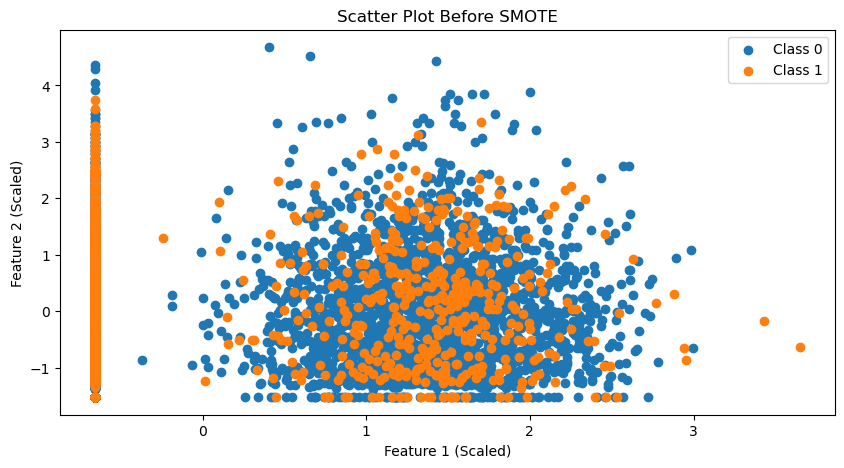

Class distribution after SMOTE: Counter({0: 6355, 1: 6355})


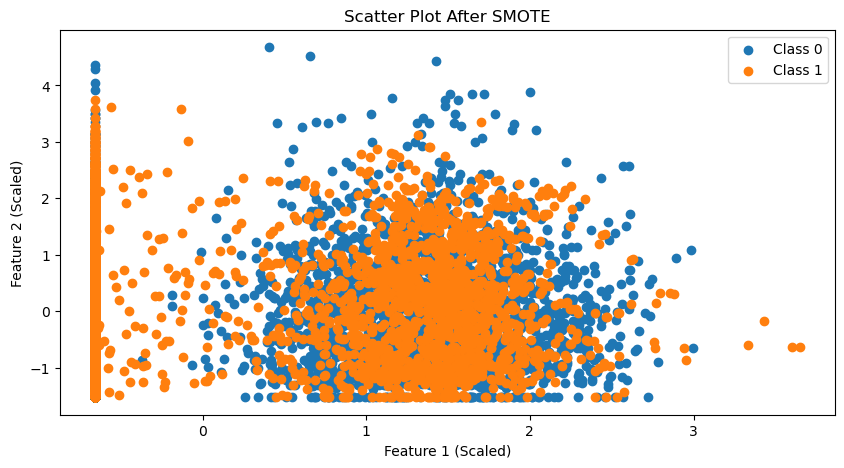

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter

# Plot "Before SMOTE"
print("Class distribution before SMOTE:", Counter(y_train))

# Scatter plot of data by class label (before SMOTE)
plt.figure(figsize=(10, 5))
for label in set(y_train):
    row_ix = np.where(y_train == label)[0]  # Get the row indices for the label
    plt.scatter(X_train_scaled[row_ix, 0], X_train_scaled[row_ix, 1], label=f"Class {label}")  # Use array indexing

plt.legend()
plt.title("Scatter Plot Before SMOTE")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.show()

# Plot "After SMOTE"
print("Class distribution after SMOTE:", Counter(y_train_smote))

# Scatter plot of data by class label (after SMOTE)
plt.figure(figsize=(10, 5))
for label in set(y_train_smote):
    row_ix = np.where(y_train_smote == label)[0]  # Get the row indices for the label
    plt.scatter(X_train_smote[row_ix, 0], X_train_smote[row_ix, 1], label=f"Class {label}")  # Use array indexing

plt.legend()
plt.title("Scatter Plot After SMOTE")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.show()

"The scatter plots above illustrate the effect of applying SMOTE to the training data. In the 'before SMOTE' plot, we observe an imbalanced dataset where the majority class significantly outnumbers the minority class. This imbalance can lead to biased model predictions favoring the majority class.
After applying SMOTE, as shown in the 'after SMOTE' plot, the dataset is balanced by generating synthetic samples for the minority class. These synthetic samples are created by interpolating between existing samples of the minority class, ensuring that the new samples are realistic.
The balanced dataset is then used to train the model, helping it learn equally from both classes and improving its ability to generalize to unseen data."

Key Takeaways
Always explain the purpose of SMOTE and how it addresses class imbalance.
Clearly state which data is being visualized in the "before" and "after" plots.
Highlight the benefits of using the balanced dataset for training, such as reducing bias and improving model performance.

We can see above with the SMOTE oversampling technique, before applying smote, the dataset had a data imbalance between the major feature in the dataset and the minor feature in the data set of 6355 for class 0 and 1645 for class 1 error respectively. After applying the SMOTE oversampling technique, we can see that the dataset has been balancedwith class 0 and class 1 both shwing a sample size of 6355. This helps to remove any bias towards the larger data sample size in the dataset due to an imbalanced dataset.

The sampling_strategy=0.4 in SMOTE is not feasible given the class distribution in your dataset. Specifically, the minority class already has too few samples, and the specified ratio would require removing samples from the minority class, which SMOTE cannot do.

## Part 1.1: Data Quality Check (Again)

In [9]:
# Exclude 'RowNumber', 'CustomerId', and 'Surname' columns
columns_to_exclude = ['RowNumber', 'CustomerId', 'Surname']
numeric_columns = churn.drop(columns=columns_to_exclude).select_dtypes(include=[np.number])
columns = [col for col in churn.columns if col not in columns_to_exclude]

# understand data structure with info()
churn.info()

# understand statistical measures with describe()
description = churn.describe()

# Convert the DataFrame to a string format with proper alignment
formatted_description = description.to_string()

print(formatted_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   RowNumber               10000 non-null  int64   
 1   CustomerId              10000 non-null  int64   
 2   Surname                 10000 non-null  object  
 3   CreditScore             10000 non-null  int64   
 4   Geography               10000 non-null  object  
 5   Gender                  10000 non-null  object  
 6   Age                     10000 non-null  int64   
 7   Tenure                  10000 non-null  int64   
 8   Balance                 10000 non-null  float64 
 9   NumOfProducts           10000 non-null  int64   
 10  HasCrCard               10000 non-null  int64   
 11  IsActiveMember          10000 non-null  int64   
 12  EstimatedSalary         10000 non-null  float64 
 13  Exited                  10000 non-null  int64   
 14  Complain               

In [10]:
# understand the data with counts for each column
for column in columns:
    print(f"Value counts for {column}:")
    print(churn[column].value_counts())

Value counts for CreditScore:
CreditScore
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: count, Length: 460, dtype: int64
Value counts for Geography:
Geography
NSW    5014
VIC    2509
QLD    2477
Name: count, dtype: int64
Value counts for Gender:
Gender
Male      5457
Female    4543
Name: count, dtype: int64
Value counts for Age:
Age
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: count, Length: 70, dtype: int64
Value counts for Tenure:
Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64
Value counts for Balance:
Balance
0.00         3617
130170.82       2
105473.74       2
85304.27        1
159397.75       1
             ... 
81556.89        1
112687.69       1
108698.96       1
238387.56       1
130142.79       1
Name: count, Length: 6382

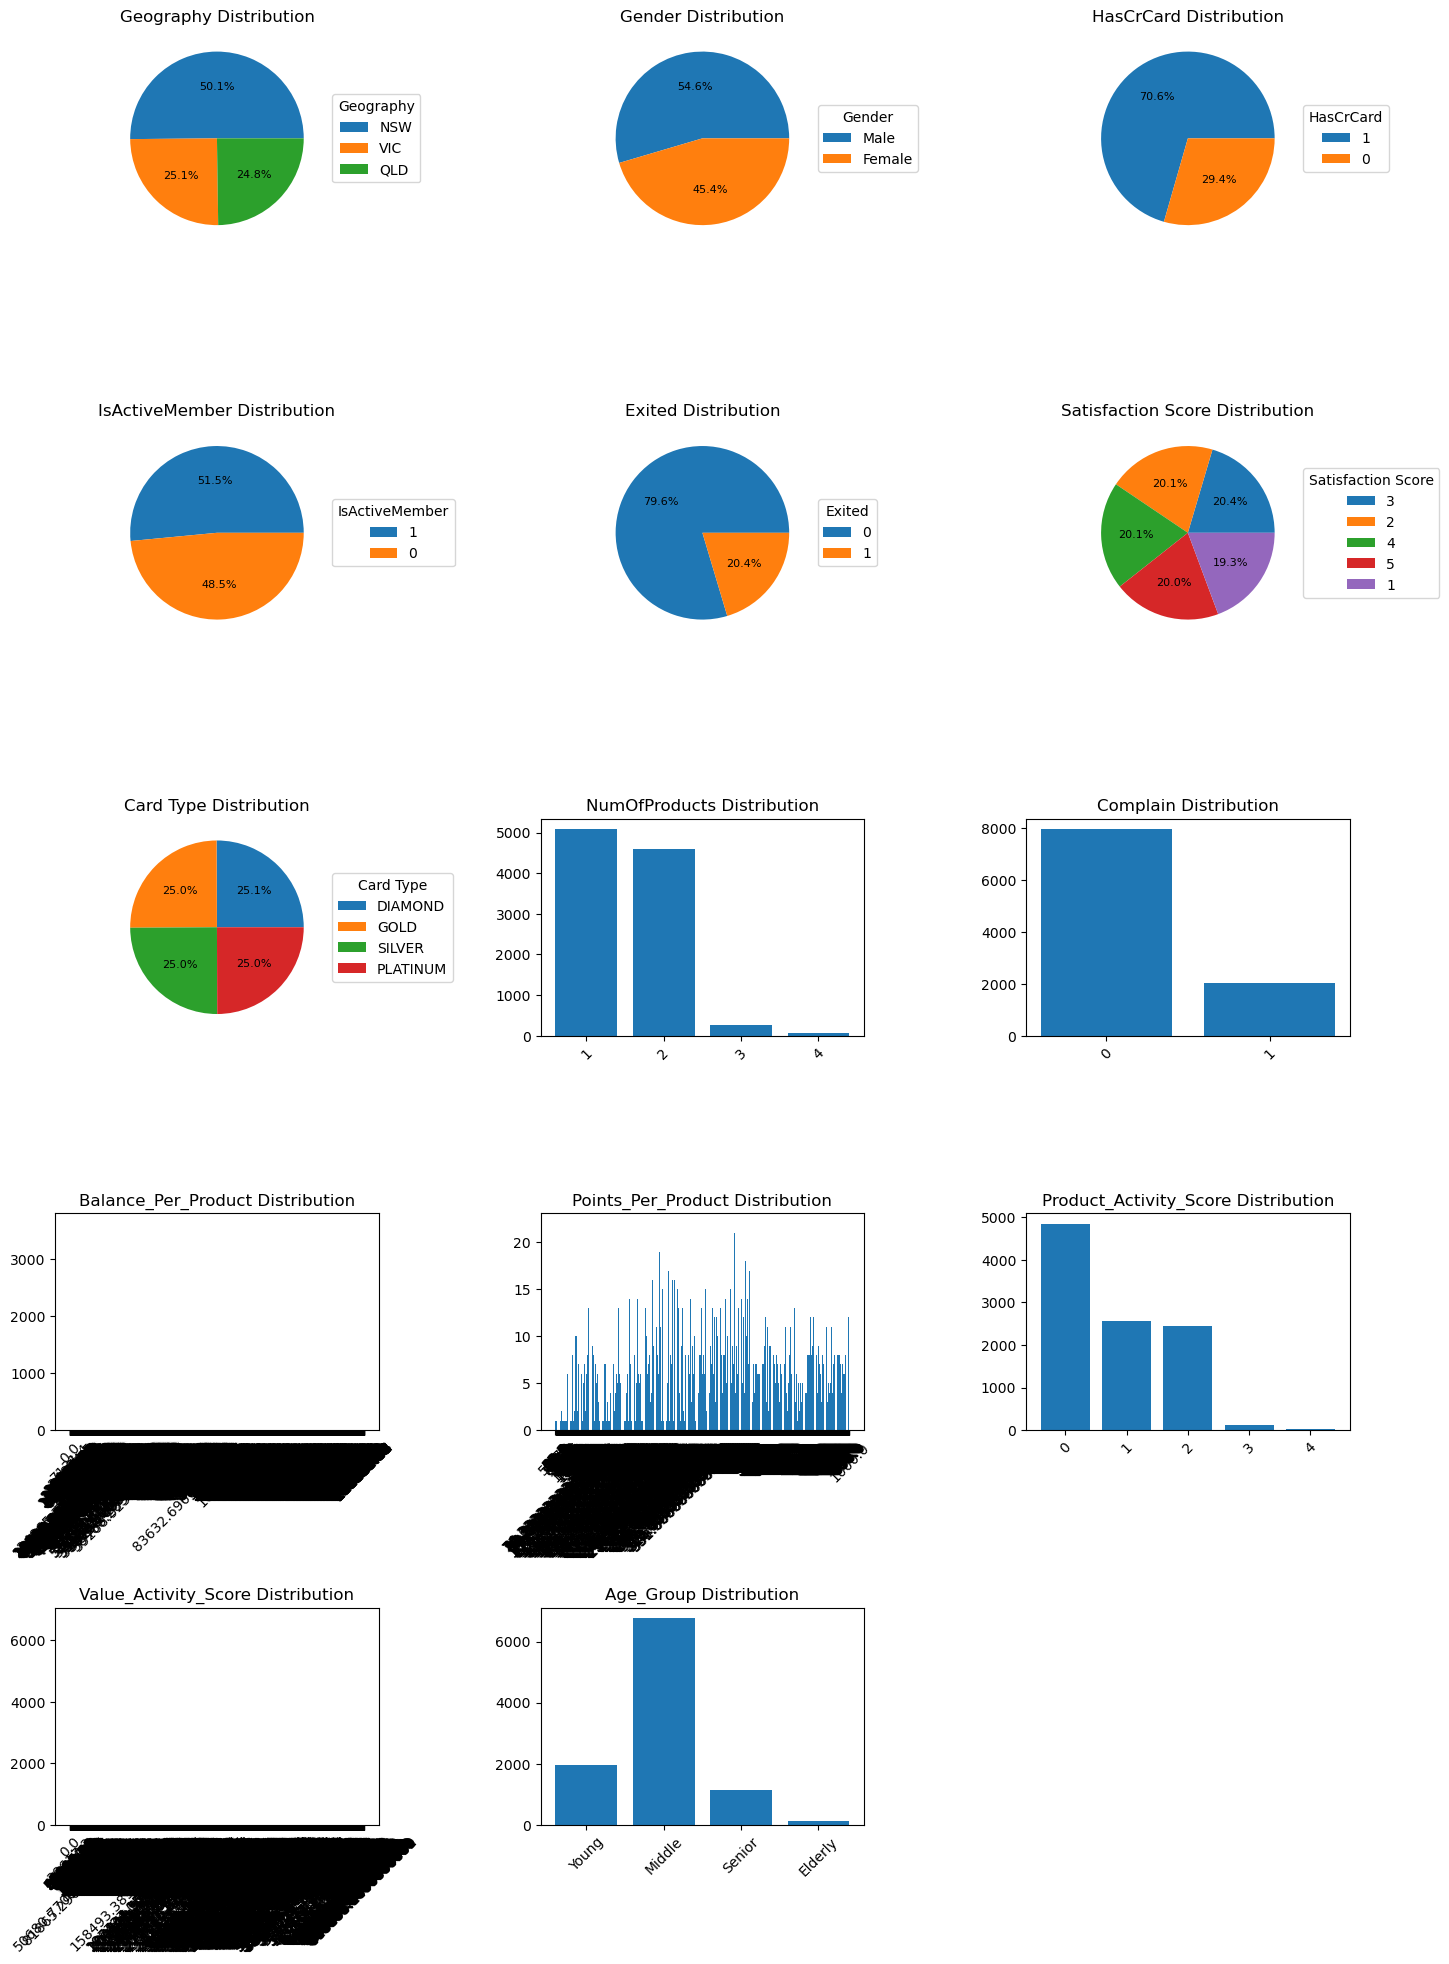

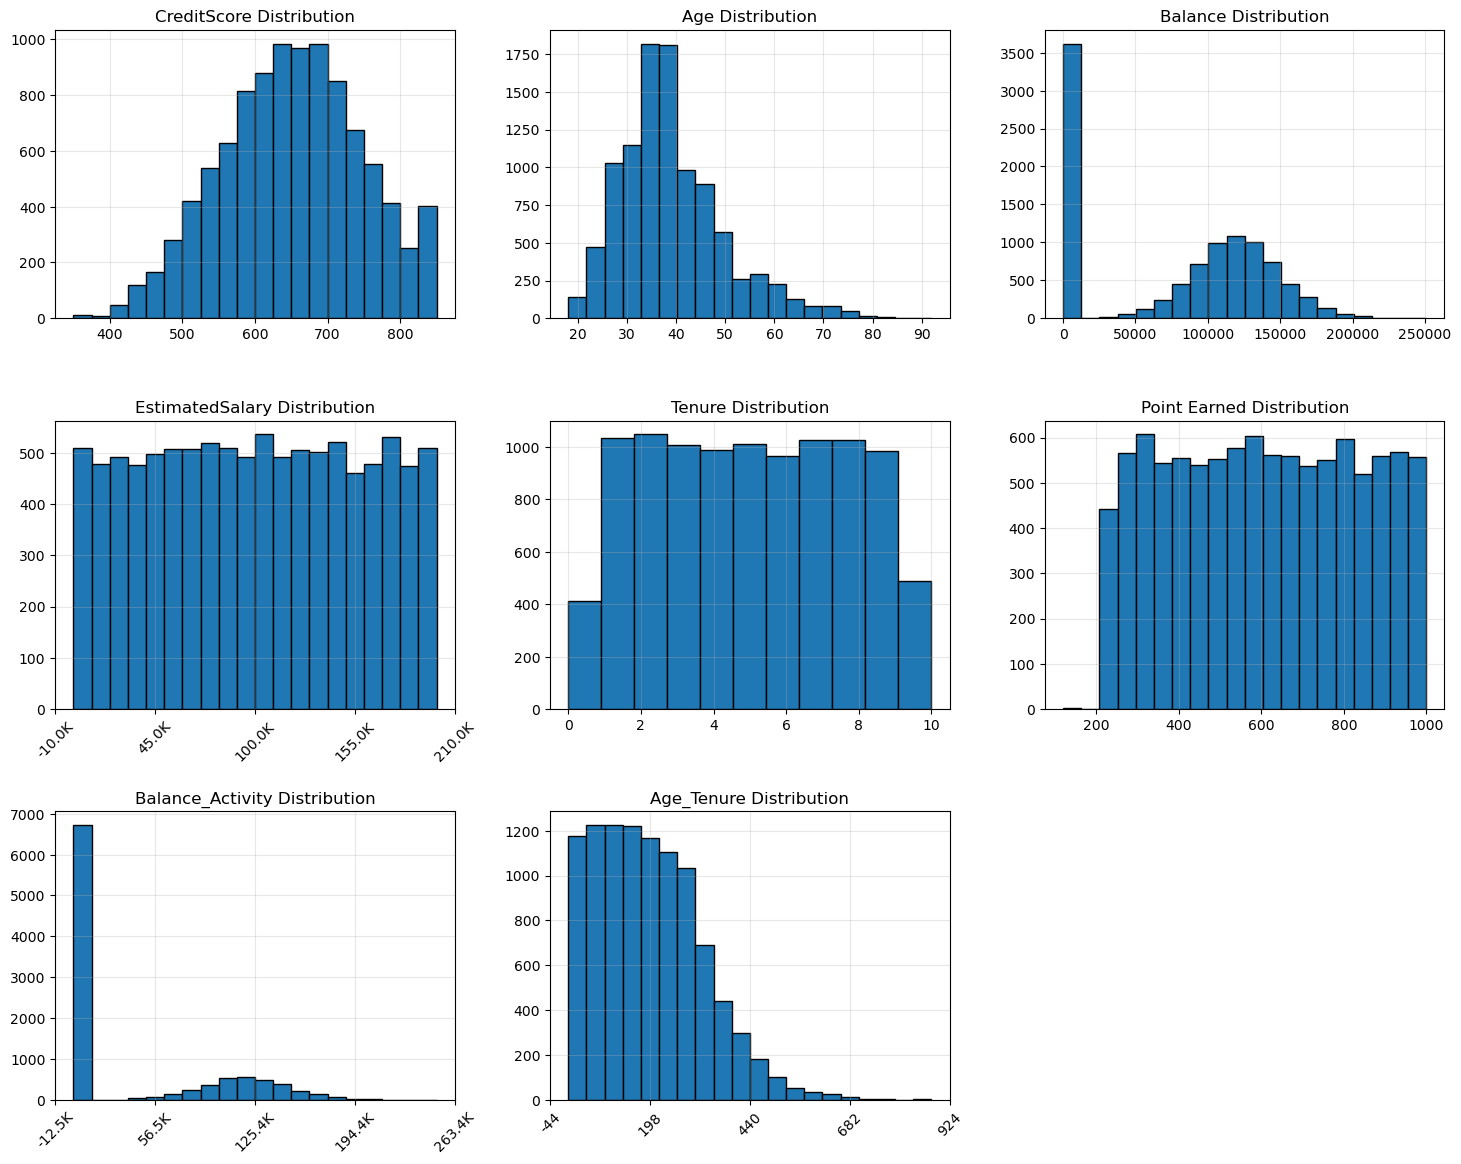

In [11]:
# Exclude 'RowNumber', 'CustomerId', and 'Surname' columns
columns_to_exclude = ['RowNumber', 'CustomerId', 'Surname']
numeric_columns = churn.drop(columns=columns_to_exclude).select_dtypes(include=[np.number])
columns = [col for col in churn.columns if col not in columns_to_exclude]

# Define which columns should get which chart types
histogram_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'Point Earned', 
                    'Balance_Activity', 'Age_Tenure']
pie_chart_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited', 'Satisfaction Score', 'Card Type']
bar_chart_columns = [col for col in columns if col not in histogram_columns and col not in pie_chart_columns]

# Define number of bins for each histogram column
bin_counts = {
    'CreditScore': 25,
    'Age': 20,
    'Balance': 30,
    'EstimatedSalary': 25,
    'Tenure': 10,
    'Point Earned': 20,
    'Balance_Activity': 30,
    'Age_Tenure': 25
}

# First figure for bar charts and pie charts
def create_non_histogram_charts():
    # Calculate the number of non-histogram plots
    non_histogram_plots = len(pie_chart_columns) + len(bar_chart_columns)

    # Calculate rows and columns for the layout
    num_cols_non_hist = min(3, non_histogram_plots)  # Use at most 3 columns
    num_rows_non_hist = (non_histogram_plots + num_cols_non_hist - 1) // num_cols_non_hist

    # Create figure for non-histogram plots
    fig_non_hist, axs_non_hist = plt.subplots(num_rows_non_hist, num_cols_non_hist,
                                              figsize=(15, 4 * num_rows_non_hist))

    # Flatten the axes array if it's multi-dimensional
    if non_histogram_plots > 1:
        axs_non_hist = axs_non_hist.flatten()
    else:
        axs_non_hist = [axs_non_hist]

    # Plot index counter
    plot_idx = 0

    # Create pie charts
    for column in pie_chart_columns:
        if plot_idx < len(axs_non_hist):
            ax = axs_non_hist[plot_idx]
            # Your existing pie chart code here
            value_counts = churn[column].value_counts()
            wedges, texts, autotexts = ax.pie(value_counts,
                                              autopct='%1.1f%%',
                                              textprops={'fontsize': 8})
            ax.set_title(f'{column} Distribution')
            ax.legend(wedges, value_counts.index, title=column, loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1))
            plot_idx += 1

    # Create bar charts
    for column in bar_chart_columns:
        if plot_idx < len(axs_non_hist):
            ax = axs_non_hist[plot_idx]
            # Your existing bar chart code here
            value_counts = churn[column].value_counts().sort_index()
            ax.bar(value_counts.index.astype(str), value_counts.values)
            ax.set_title(f'{column} Distribution')
            ax.tick_params(axis='x', rotation=45)
            plot_idx += 1

    # Hide any unused subplots
    for i in range(plot_idx, len(axs_non_hist)):
        axs_non_hist[i].set_visible(False)

    plt.tight_layout(pad=2.0)
    return fig_non_hist

# Second figure for histograms
def create_histogram_charts():
    # Calculate layout for histograms
    num_hist_plots = len(histogram_columns)
    num_cols_hist = min(3, num_hist_plots)
    num_rows_hist = (num_hist_plots + num_cols_hist - 1) // num_cols_hist

    # Create figure for histogram plots
    fig_hist, axs_hist = plt.subplots(num_rows_hist, num_cols_hist,
                                     figsize=(15, 4 * num_rows_hist))

    # Flatten the axes array if it's multi-dimensional
    if num_hist_plots > 1:
        axs_hist = axs_hist.flatten()
    else:
        axs_hist = [axs_hist]

    # Create histograms
    for i, column in enumerate(histogram_columns):
        if i < len(axs_hist):
            ax = axs_hist[i]
            
            # Your existing histogram code here
            num_bins = min(20, len(churn[column].unique()))
            ax.hist(churn[column], bins=num_bins, edgecolor='black')
            ax.set_title(f'{column} Distribution')
            
            # Control x-axis ticks based on the column
            if column in ['Balance_Activity', 'Age_Tenure', 'EstimatedSalary']:
                # Get current x-axis limits
                x_min, x_max = ax.get_xlim()
                
                # Create 5 evenly spaced ticks
                ticks = np.linspace(x_min, x_max, 5)
                
                # Format large numbers with K/M suffix
                def format_tick(x):
                    if abs(x) >= 1e6:
                        return f'{x/1e6:.1f}M'
                    elif abs(x) >= 1e3:
                        return f'{x/1e3:.1f}K'
                    else:
                        return f'{x:.0f}'
                
                # Set new ticks and format them
                ax.set_xticks(ticks)
                ax.set_xticklabels([format_tick(x) for x in ticks], rotation=45)
            
            # Add grid for better readability
            ax.grid(True, alpha=0.3)

    # Hide any unused subplots
    for i in range(num_hist_plots, len(axs_hist)):
        axs_hist[i].set_visible(False)

    plt.tight_layout(pad=2.0)
    return fig_hist

# Create and display the first figure (non-histogram charts)
fig_non_hist = create_non_histogram_charts()
plt.figure(fig_non_hist.number)
plt.show()

# Create and display the second figure (histograms)
fig_hist = create_histogram_charts()
plt.figure(fig_hist.number)
plt.show()

In [12]:
# Duplicate checking
# Check for duplicate rows
print(churn[churn.duplicated(subset=churn.columns)])

# Check for duplicate primary keys
print(churn[churn.duplicated(subset='CustomerId')])

Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited, Complain, Satisfaction Score, Card Type, Point Earned, Balance_Activity, Age_Tenure, Balance_Per_Product, Points_Per_Product, Product_Activity_Score, Value_Activity_Score, Age_Group]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited, Complain, Satisfaction Score, Card Type, Point Earned, Balance_Activity, Age_Tenure, Balance_Per_Product, Points_Per_Product, Product_Activity_Score, Value_Activity_Score, Age_Group]
Index: []

[0 rows x 25 columns]


In [13]:
# Check for missing values in the dataset
print("\nMissing Values Check:")
print(df.isnull().sum())

# Get percentage of missing values
print("\nPercentage of Missing Values:")
print((df.isnull().sum() / len(df) * 100).round(2))

# Quick summary of the dataset
print("\nDataset Info:")
print(df.info())


Missing Values Check:
RowNumber                 0
CustomerId                0
Surname                   0
CreditScore               0
Age                       0
Tenure                    0
Balance                   0
NumOfProducts             0
HasCrCard                 0
IsActiveMember            0
EstimatedSalary           0
Exited                    0
Complain                  0
Satisfaction Score        0
Point Earned              0
Balance_Activity          0
Age_Tenure                0
Balance_Per_Product       0
Points_Per_Product        0
Product_Activity_Score    0
Value_Activity_Score      0
Age_Young                 0
Age_Middle                0
Age_Senior                0
Age_Elderly               0
Products_Per_Age          0
Balance_Credit_Ratio      0
Risk_Score                0
Tenure_Product_Ratio      0
Satisfaction_Activity     0
Geography_QLD             0
Geography_VIC             0
Gender_Male               0
Card Type_GOLD            0
Card Type_PLATINUM       

In [14]:
# check whether values are within range
# Define acceptable range
# Check if all CreditScores are within range
def check_column_ranges(df, columns_to_exclude=['RowNumber', 'CustomerId']):
    """
    Check if values in each column are within expected ranges

    Args:
        df: DataFrame to check
        columns_to_exclude: List of columns to skip in the check

    Returns:
        Dictionary with results for each column including pass/fail status
    """
    results = {}

    # Get list of columns to check (excluding specified ones)
    columns_to_check = [col for col in df.columns if col not in columns_to_exclude]

    for column in columns_to_check:
        # Skip non-numeric columns for range checks
        if not pd.api.types.is_numeric_dtype(df[column]):
            results[column] = {
                'status': 'SKIPPED',
                'message': f"Non-numeric column type: {df[column].dtype}",
                'details': None
            }
            continue

        # Get column min and max values
        min_val = df[column].min()
        max_val = df[column].max()

        # Define expected ranges based on column type/name
        if column == 'CreditScore':
            expected_min, expected_max = 350, 850
        elif column == 'Age':
            expected_min, expected_max = 18, 100
        elif column == 'Tenure':
            expected_min, expected_max = 0, 10
        elif column == 'Balance':
            expected_min, expected_max = 0, float('inf')
        elif column == 'NumOfProducts':
            expected_min, expected_max = 1, 4
        elif column == 'EstimatedSalary':
            expected_min, expected_max = 0, float('inf')
        elif column in ['HasCrCard', 'IsActiveMember', 'Exited']:
            expected_min, expected_max = 0, 1
        else:
            results[column] = {
                'status': 'INFO',
                'message': f"No range check defined",
                'details': f"Current range: [{min_val}, {max_val}]"
            }
            continue

        # Check if values are within expected range
        out_of_range = df[~((df[column] >= expected_min) & (df[column] <= expected_max))]
        out_of_range_count = len(out_of_range)

        if out_of_range_count > 0:
            results[column] = {
                'status': 'FAIL',
                'message': f"{out_of_range_count} values outside expected range [{expected_min}, {expected_max}]",
                'details': {
                    'total_rows': len(df),
                    'invalid_count': out_of_range_count,
                    'invalid_percent': f"{(out_of_range_count/len(df))*100:.2f}%",
                    'actual_range': f"[{min_val}, {max_val}]",
                    'expected_range': f"[{expected_min}, {expected_max}]"
                }
            }
        else:
            results[column] = {
                'status': 'PASS',
                'message': f"All values within expected range [{expected_min}, {expected_max}]",
                'details': {
                    'total_rows': len(df),
                    'actual_range': f"[{min_val}, {max_val}]"
                }
            }

    return results

# Run the check on your churn dataframe
range_check_results = check_column_ranges(churn)

# Display results in a readable format with color coding
print("\nColumn Range Check Results:")
print("="*50)

for column, result in range_check_results.items():
    status = result['status']
    status_color = {
        'PASS': '\033[92m',  # Green
        'FAIL': '\033[91m',  # Red
        'SKIPPED': '\033[93m',  # Yellow
        'INFO': '\033[94m'  # Blue
    }.get(status, '')
    reset_color = '\033[0m'
    
    print(f"\n{column}:")
    print(f"Status: {status_color}{status}{reset_color}")
    print(f"Message: {result['message']}")
    if result['details']:
        print("Details:")
        if isinstance(result['details'], dict):
            for key, value in result['details'].items():
                print(f"  - {key}: {value}")
        else:
            print(f"  {result['details']}")


Column Range Check Results:

Surname:
Status: SKIPPED
Message: Non-numeric column type: object

CreditScore:
Status: PASS
Message: All values within expected range [350, 850]
Details:
  - total_rows: 10000
  - actual_range: [350, 850]

Geography:
Status: SKIPPED
Message: Non-numeric column type: object

Gender:
Status: SKIPPED
Message: Non-numeric column type: object

Age:
Status: PASS
Message: All values within expected range [18, 100]
Details:
  - total_rows: 10000
  - actual_range: [18, 92]

Tenure:
Status: PASS
Message: All values within expected range [0, 10]
Details:
  - total_rows: 10000
  - actual_range: [0, 10]

Balance:
Status: PASS
Message: All values within expected range [0, inf]
Details:
  - total_rows: 10000
  - actual_range: [0.0, 250898.09]

NumOfProducts:
Status: PASS
Message: All values within expected range [1, 4]
Details:
  - total_rows: 10000
  - actual_range: [1, 4]

HasCrCard:
Status: PASS
Message: All values within expected range [0, 1]
Details:
  - total_rows

In [15]:
# Define regular special characters
pattern = r'[!@#$%^&*()_+?=\{};:\,.<>/|`~\"\[\]]'


special_char_count = 0
max_examples_to_show = 10  # Limit to show only first 10 examples
special_char_types = {}  # Dictionary to track counts of each special character

# Scan the 'surname' column for special characters
for x in churn['Surname']:
    special_characters = re.findall(pattern, x)
    if special_characters:
        special_char_count += 1

        # Count occurrences of each special character
        for char in special_characters:
            if char in special_char_types:
                special_char_types[char] += 1
            else:
                special_char_types[char] = 1

        # Only print if we're still under the limit
        if special_char_count <= max_examples_to_show:
            print(f"Special characters found in '{x}': {special_characters}")
        elif special_char_count == max_examples_to_show + 1:
            print("... (more examples omitted)")

# Print the total count after scanning all surnames
print(f"\nTotal surnames containing special characters: {special_char_count}")
print(f"Percentage of surnames with special characters: {special_char_count / len(churn['Surname']) * 100:.2f}%")

# Print the distribution of special character types
print("\nDistribution of special characters:")
for char, count in sorted(special_char_types.items(), key=lambda x: x[1], reverse=True):
    print(
        f"'{char}': {count} occurrences ({count / sum(special_char_types.values()) * 100:.2f}% of all special characters)")

Special characters found in 'H?': ['?']
Special characters found in 'L?': ['?']
Special characters found in 'Hs?': ['?']
Special characters found in 'Y?an': ['?']
Special characters found in 'L?': ['?']
Special characters found in 'Y?an': ['?']
Special characters found in 'L?': ['?']
Special characters found in 'H?': ['?']
Special characters found in 'K?': ['?']
Special characters found in 'L?': ['?']
... (more examples omitted)

Total surnames containing special characters: 92
Percentage of surnames with special characters: 0.92%

Distribution of special characters:
'?': 92 occurrences (100.00% of all special characters)


In [16]:
# Scan the 'EstimatedSalary' column for non-numeric characters
found_non_numeric = False
for x in churn['EstimatedSalary']:
    non_numeric = re.findall("[a-zA-Z]", str(x))
    if non_numeric:
        print(f"Non-numeric characters found in", x)
        found_non_numeric = True

if not found_non_numeric:
    print("All characters are numeric in EstimatedSalary column")

All characters are numeric in EstimatedSalary column


## Part 1.2: Random Forest Model

In [17]:
# Build a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=40)

# Train the classifier on the SMOTE-balanced, scaled training data
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions and get probabilities
y_pred_rf = rf_model.predict(X_test_scaled)
y_scores_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# RF initial results 
rf_initial_metrics = {
    'accuracy': metrics.accuracy_score(y_test, y_pred_rf),
    'precision': metrics.precision_score(y_test, y_pred_rf),
    'recall': metrics.recall_score(y_test, y_pred_rf),
    'f1_score': metrics.f1_score(y_test, y_pred_rf),
    'auc': metrics.roc_auc_score(y_test, y_scores_rf)
}

rf_initial_parameters = {
    'n_estimators': 100,  # default parameters
    'random_state': 40
}

# Evaluate the model's performance - use y_pred_rf instead of y_pred
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Changes made after SMOTE and scaling:
# X_train → X_train_smote
# y_train → y_train_smote
# X_test → X_test_scaled
# y_test remains unchanged as we don't scale target variables

# Remember that:

# Training is done on the SMOTE-balanced and scaled data (X_train_smote, y_train_smote)
# Testing is done on the scaled test data (X_test_scaled)
# The test labels (y_test) remain in their original form



Accuracy: 85.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.64      0.60      0.62       393

    accuracy                           0.86      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.85      0.86      0.85      2000



### Part 1.2.1: Visualising the Random Forest

Confusion Matrix:
[[1476  131]
 [ 158  235]]


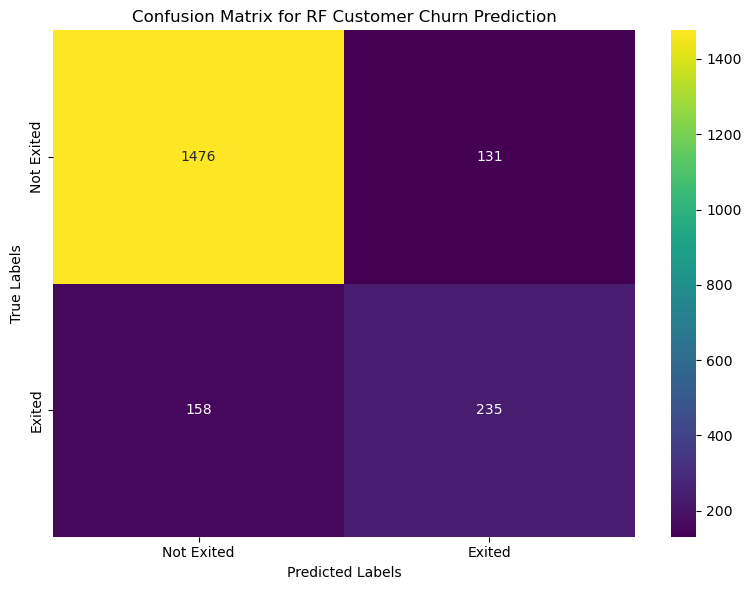

C:\Users\willj\AppData\Local\Temp\ipykernel_25048\2890198772.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


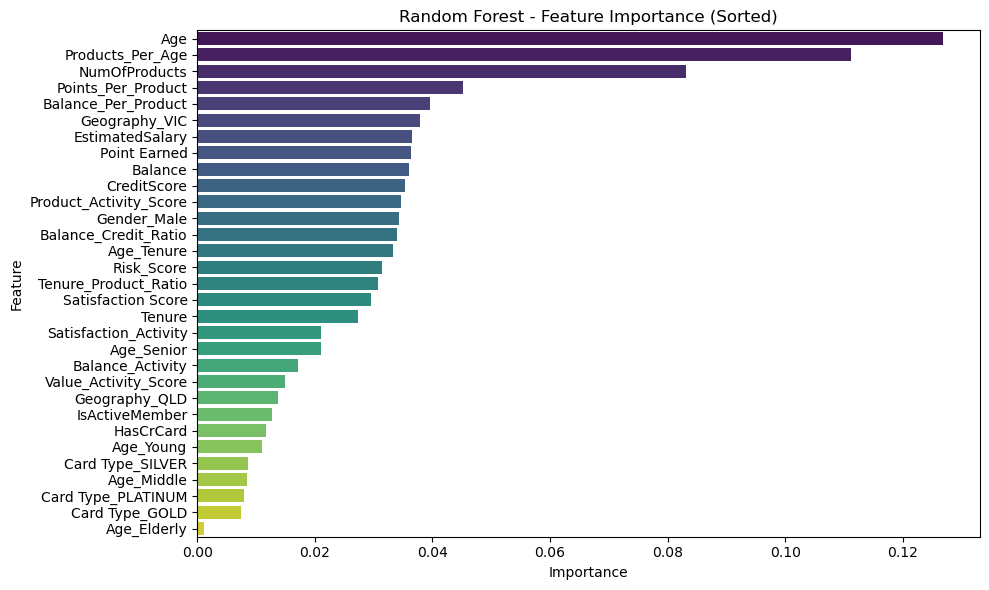

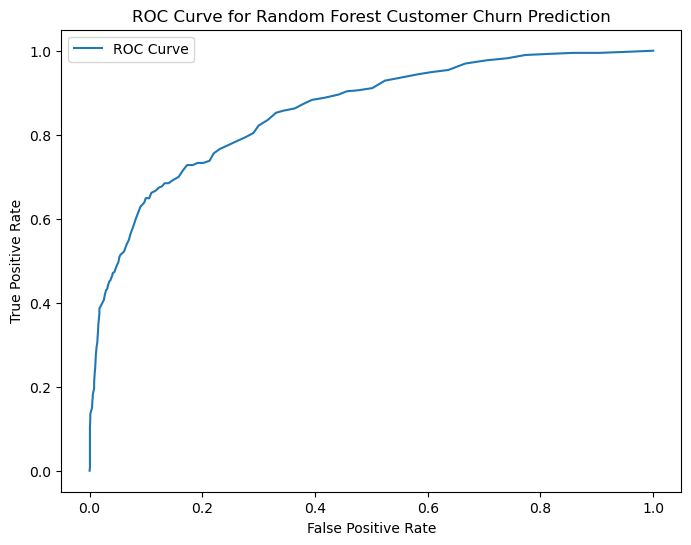

AUC: 0.8568595410346906


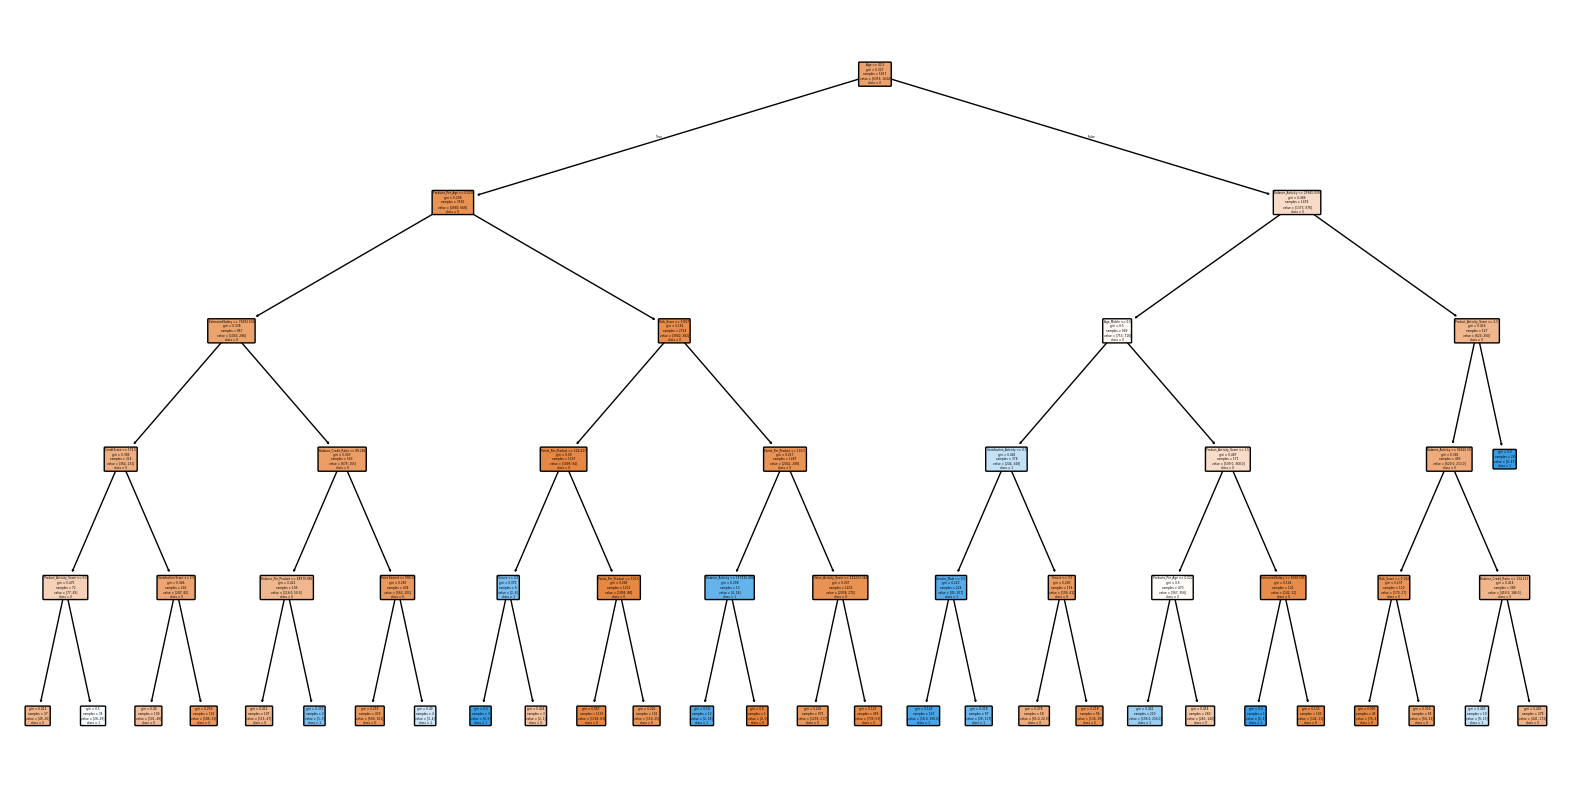

In [18]:
# Confusion Matrix using the Random Forest predictions
y_pred = rf_model.predict(X_test_scaled)  # Using rf_model instead of dt_model
cm = metrics.confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

# Confusion Matrix interpretation: True Negatives (top left), False Positives (top right), False Negatives (bottom left), True Positives (bottom right)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Not Exited', 'Exited'], 
            yticklabels=['Not Exited', 'Exited'])
plt.title('Confusion Matrix for RF Customer Churn Prediction')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Model Evaluation

# Feature Importance Visualization
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Create and sort feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Random Forest - Feature Importance (Sorted)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Get predicted probabilities for ROC curve
y_scores = rf_model.predict_proba(X_test_scaled)[:, 1]  # Using rf_model instead of dt_model

# Calculate and visualize ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Customer Churn Prediction')
plt.legend()
plt.show()

# Calculate AUC
auc = metrics.roc_auc_score(y_test, y_scores)
print(f'AUC: {auc}')


# Tree Visualisation

# Building and training a random forest classifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5) # Setting max_depth to 5 for better visualization
rf_model.fit(X_train, y_train)

# Extract one tree from the forest (the first tree)
single_tree = rf_model.estimators_[0]

# Plotting the tree

plt.figure(figsize=(20, 10))

plot_tree(single_tree, feature_names=feature_names, class_names=['0', '1'], filled=True, rounded=True, max_depth=5)

plt.show()


In [19]:
# RF initial results
rf_initial_metrics = {
    'accuracy': metrics.accuracy_score(y_test, y_pred_rf),
    'precision': metrics.precision_score(y_test, y_pred_rf),
    'recall': metrics.recall_score(y_test, y_pred_rf),
    'f1_score': metrics.f1_score(y_test, y_pred_rf),
    'auc': metrics.roc_auc_score(y_test, y_scores_rf)
}

rf_initial_parameters = {
    'n_estimators': 100,  # default parameters
    'random_state': 40
}

log_model_results(
    model_name='RF',
    stage='Initial Model',
    parameters=rf_initial_parameters,
    metrics=rf_initial_metrics
)

Results logged successfully to model_results_log.csv


## Part 1.3: Gradient Boosting Machine Model (GBM)

In [20]:
#  Boosting Machines (GBMs)

# Build a Gradient Boosting Model
gbm = GradientBoostingClassifier(n_estimators=100, random_state=40)

# Train the classifier on the SMOTE-balanced, scaled training data
gbm.fit(X_train_smote, y_train_smote)

# Make predictions on the scaled test set
y_pred_gbm = gbm.predict(X_test_scaled)
y_scores_gbm = gbm.predict_proba(X_test_scaled)[:, 1]

# GBM initial results
gbm_initial_metrics = {
    'accuracy': metrics.accuracy_score(y_test, y_pred_gbm),
    'precision': metrics.precision_score(y_test, y_pred_gbm),
    'recall': metrics.recall_score(y_test, y_pred_gbm),
    'f1_score': metrics.f1_score(y_test, y_pred_gbm),
    'auc': metrics.roc_auc_score(y_test, y_scores_gbm)
}

gbm_initial_parameters = {
    'n_estimators': 100,
    'random_state': 40
}

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Key changes:

# X_train → X_train_smote
# y_train.values.ravel() → y_train_smote
# X_test → X_test_scaled
# y_test remains unchanged as we don't scale target variables

# Remember that:

# Training is done on the SMOTE-balanced and scaled data (X_train_smote, y_train_smote)
# Testing is done on the scaled test data (X_test_scaled)
# The test labels (y_test) remain in their original form


Accuracy: 85.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.64      0.60      0.62       393

    accuracy                           0.86      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.85      0.86      0.85      2000



### Part 1.3.1: Visualising GBM


Confusion Matrix:
[[1459  148]
 [ 149  244]]


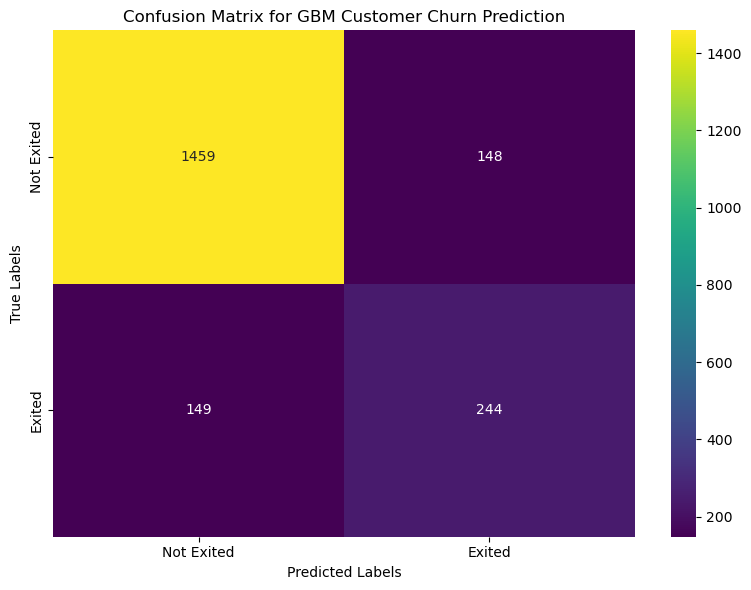

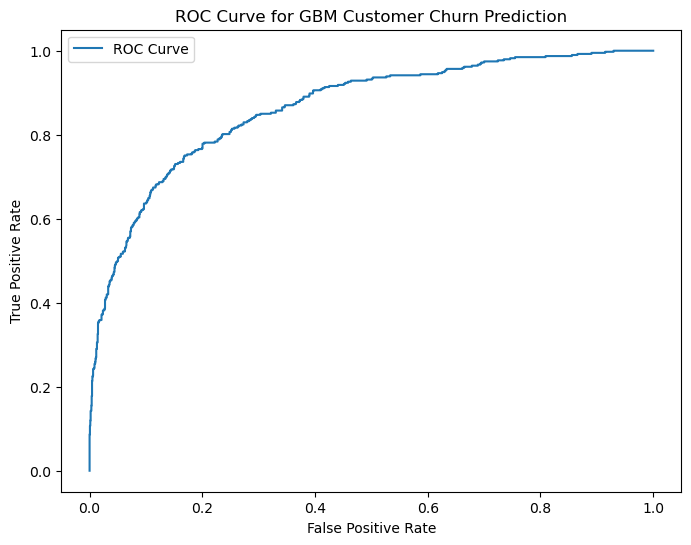

AUC: 0.8648398941653169


C:\Users\willj\AppData\Local\Temp\ipykernel_25048\1894879950.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


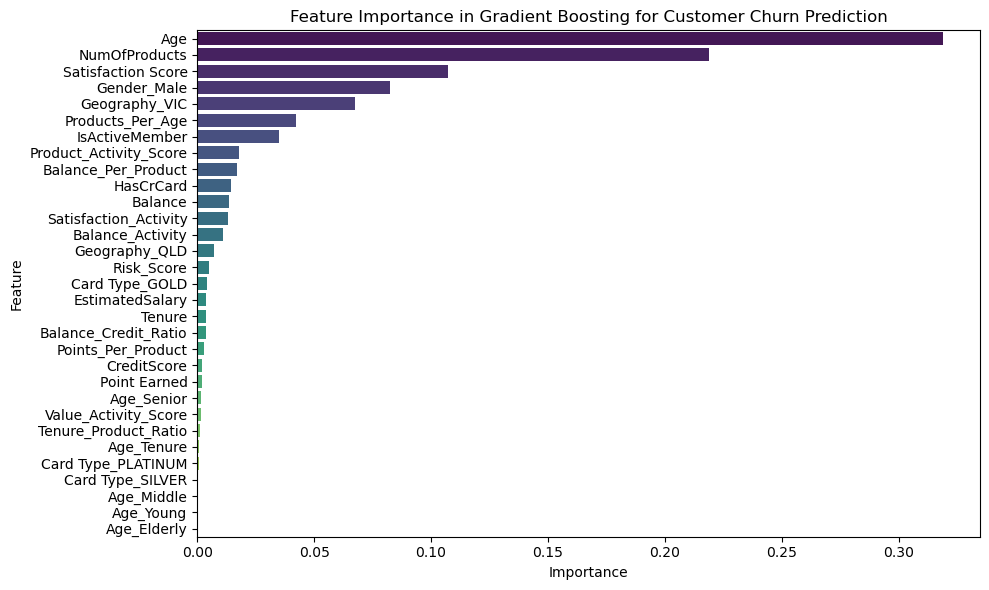

In [21]:
# Initialize and train GBM model first
gbm = GradientBoostingClassifier(n_estimators=100, random_state=40)
gbm.fit(X_train_smote, y_train_smote)

# Make new predictions specifically for GBM
gbm_pred = gbm.predict(X_test_scaled)  # New variable for GBM predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, gbm_pred)  # Use GBM predictions
print('\nConfusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Not Exited', 'Exited'], 
            yticklabels=['Not Exited', 'Exited'])
plt.title('Confusion Matrix for GBM Customer Churn Prediction')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Model Evaluation with GBM probabilities 
y_scores = gbm.predict_proba(X_test_scaled)[:, 1]

# Calculate and visualize ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Customer Churn Prediction')
plt.legend()
plt.show()

# Calculate AUC
auc = metrics.roc_auc_score(y_test, y_scores)
print(f'AUC: {auc}')

# Visualize Feature Importance for GBM
feature_importance = gbm.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance in Gradient Boosting for Customer Churn Prediction')
plt.tight_layout()
plt.show()

In [22]:
# GBM initial results
gbm_initial_metrics = {
    'accuracy': metrics.accuracy_score(y_test, y_pred_gbm),
    'precision': metrics.precision_score(y_test, y_pred_gbm),
    'recall': metrics.recall_score(y_test, y_pred_gbm),
    'f1_score': metrics.f1_score(y_test, y_pred_gbm),
    'auc': metrics.roc_auc_score(y_test, y_scores_gbm)
}

gbm_initial_parameters = {
    'n_estimators': 100,
    'random_state': 40
}

log_model_results(
    model_name='GBM',
    stage='Initial Model',
    parameters=gbm_initial_parameters,
    metrics=gbm_initial_metrics
)

Results logged successfully to model_results_log.csv


## Part 1.4: Model Performance and Comparison

### Part 1.4.1: Random Forest Model Performance

In [23]:
# Random Forest Model Performance is above under section 1.2 Random Forest Model. Includes accuracy, precision and recall. Includes Confusion Matrix, but no visualisation. Can be found in the week 2 lecture code.

Accuracy: 86.80%
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.48      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.86      2000

AUC: 0.8175428429374666
Confusion Matrix:
[[1563   44]
 [ 249  144]]
Precision: 0.7659574468085106, Recall: 0.366412213740458, Accuracy: 0.8535

### Part 1.4.2: Gradient Boosting Machine (GBM) Model Performance

In [24]:
# GBM Model Performance is above under section 1.3 GBM Model. Includes accuracy, precision and recall. Includes Confusion Matrix, but no visualisation. Can be found in the week 2 lecture code.




Accuracy: 86.50%
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.74      0.48      0.58       393

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000


Confusion Matrix:
[[1541   66]
 [ 204  189]]

AUC: 0.8175428429374666


### Part 1.4.3: Random Forest vs. Gradient Boosting Machine (GBM) Comparison

**Receiver Operating Characteristic (ROC) Curve**
* Visual representation of a model's ability to distinguish between classes.
* Plots the true positive rate against the false positive rate at different threshold settings.
* A perfect classifier has a ROC curve that hugs the upper left corner with a True Positive Rate of 1 and a False Positive Rate of 0.
* A diagonal line from 0,0 to 1,1 represents a classifier with no discriminative power, performing no better than random guessing.

(Topic 5.1, ROC Curve)

**Area Under Curve (AUC)**
* AUC values range from 0 to 1.
* Higher AUC indicate better model performance.
* An AUC of 1.0 has perfect discrimination.
* An AUC of 0.5 performs no better than a random chance.
* While ROC/AUC is a useful metric, it may not be sufficient for evaluating the performance of a model in all situations.


(Topic 5.1, AUC, Applications).

**Precision**

[WRITE PRECISION SUMMARY]

**Recall**

[WRITE RECALL SUMMARY]

**Accuracy**

[WRITE ACCURACY SUMMARY]

**F1**
[WRITE F1 SUMMARY]

In [25]:
# This section can be Markdown to include the performance metrics for both models, including ROC_AUC, Confusion Matrix, and other metrics like precision, recall, and accuracy. Insert a table with the values and write a summary. Topic 5.3 fopr more details.

## Part 1.5: Checking for Overfitting, Underfitting and Data Leakage

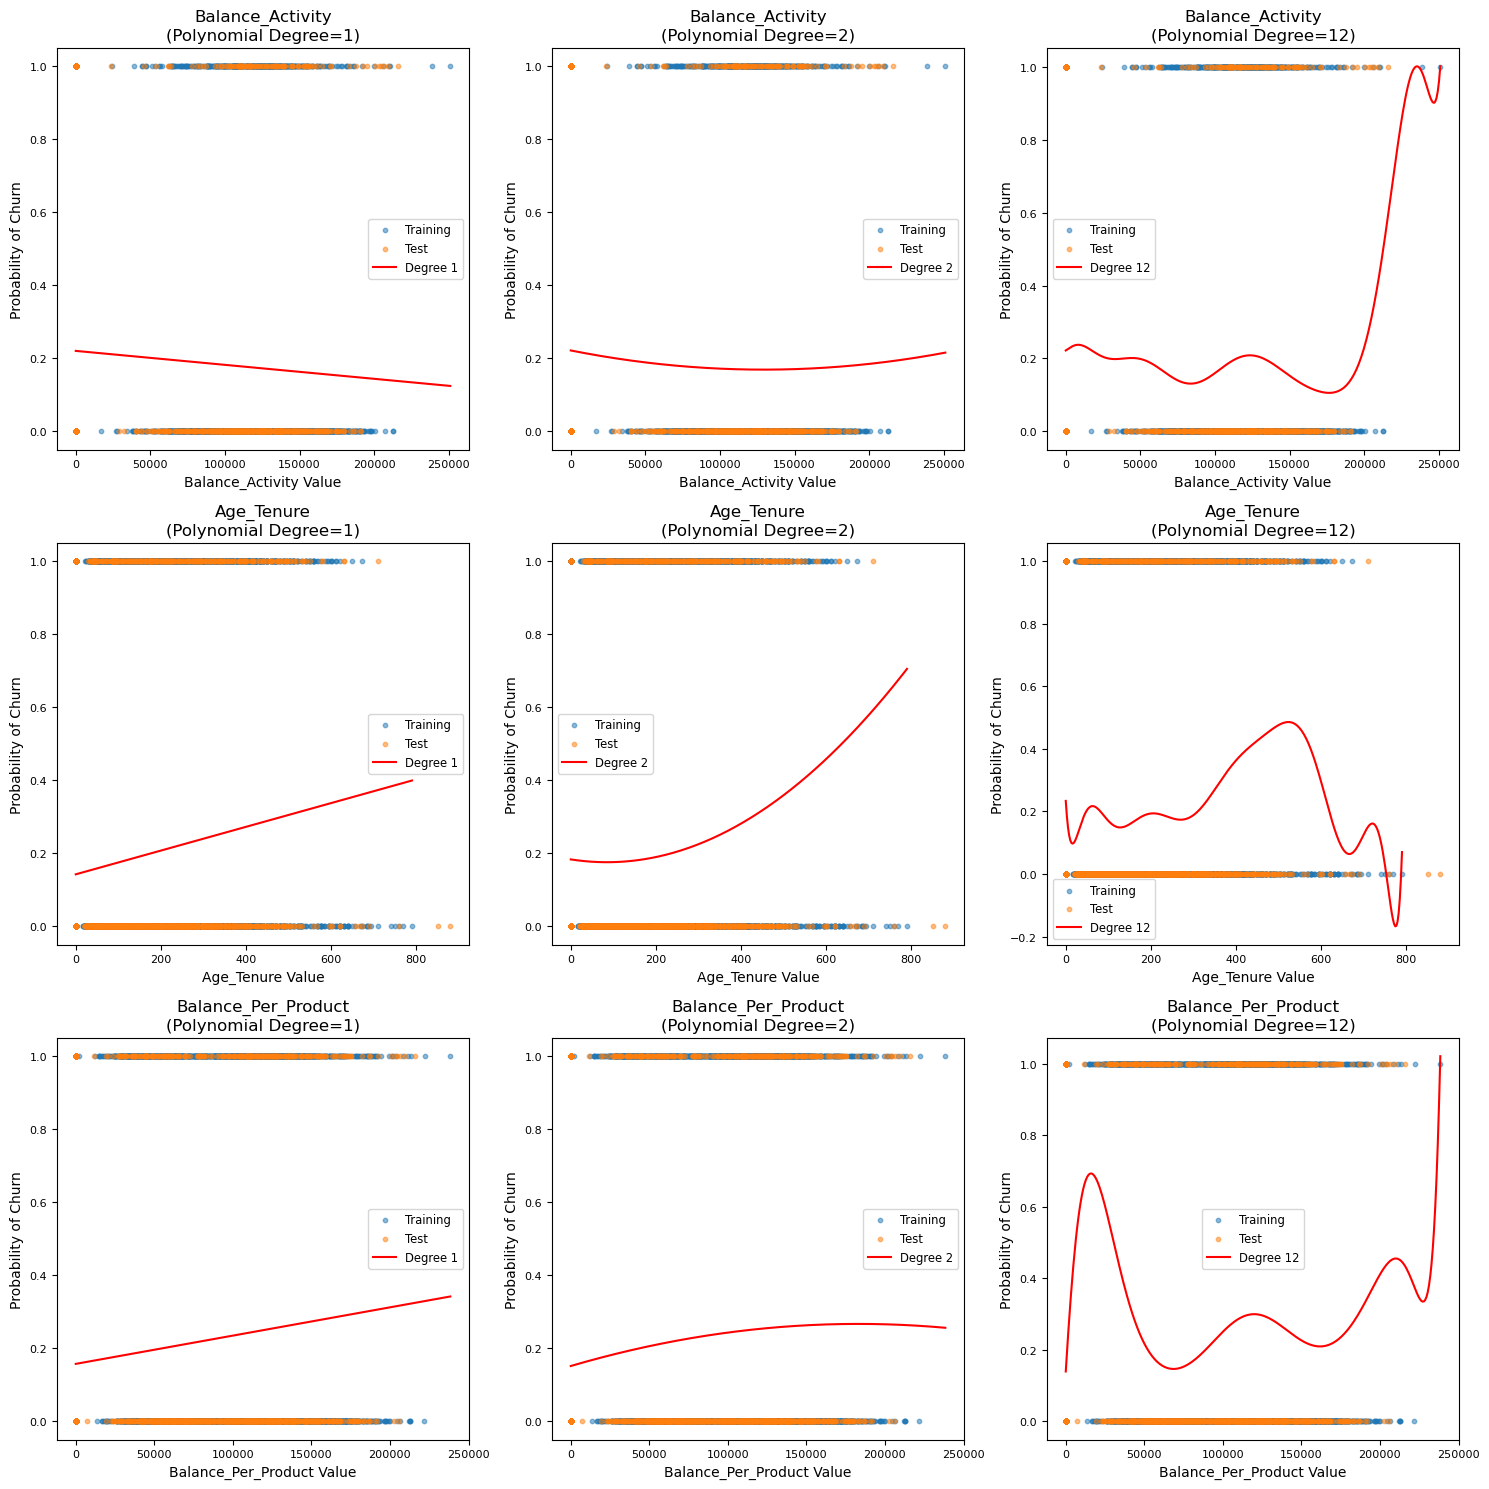

C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)


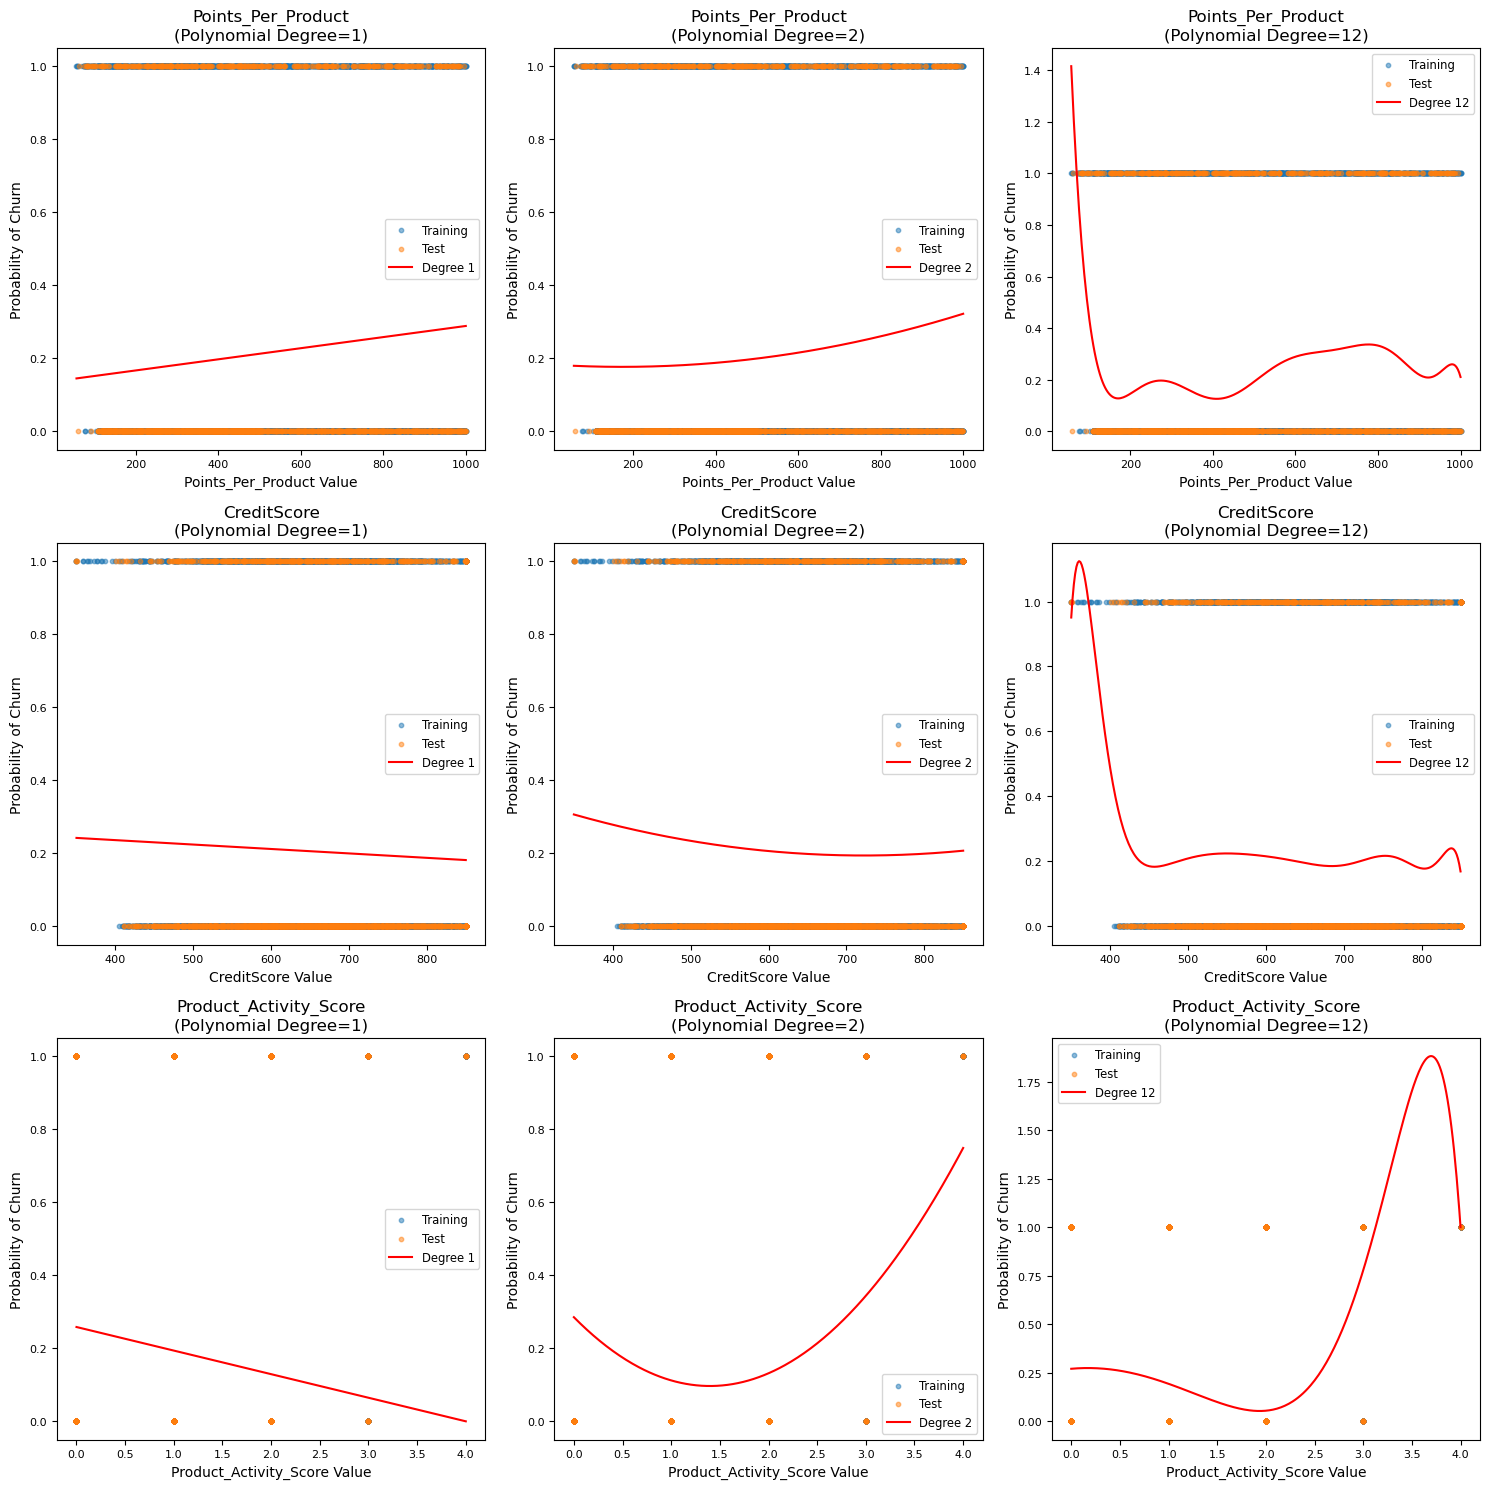

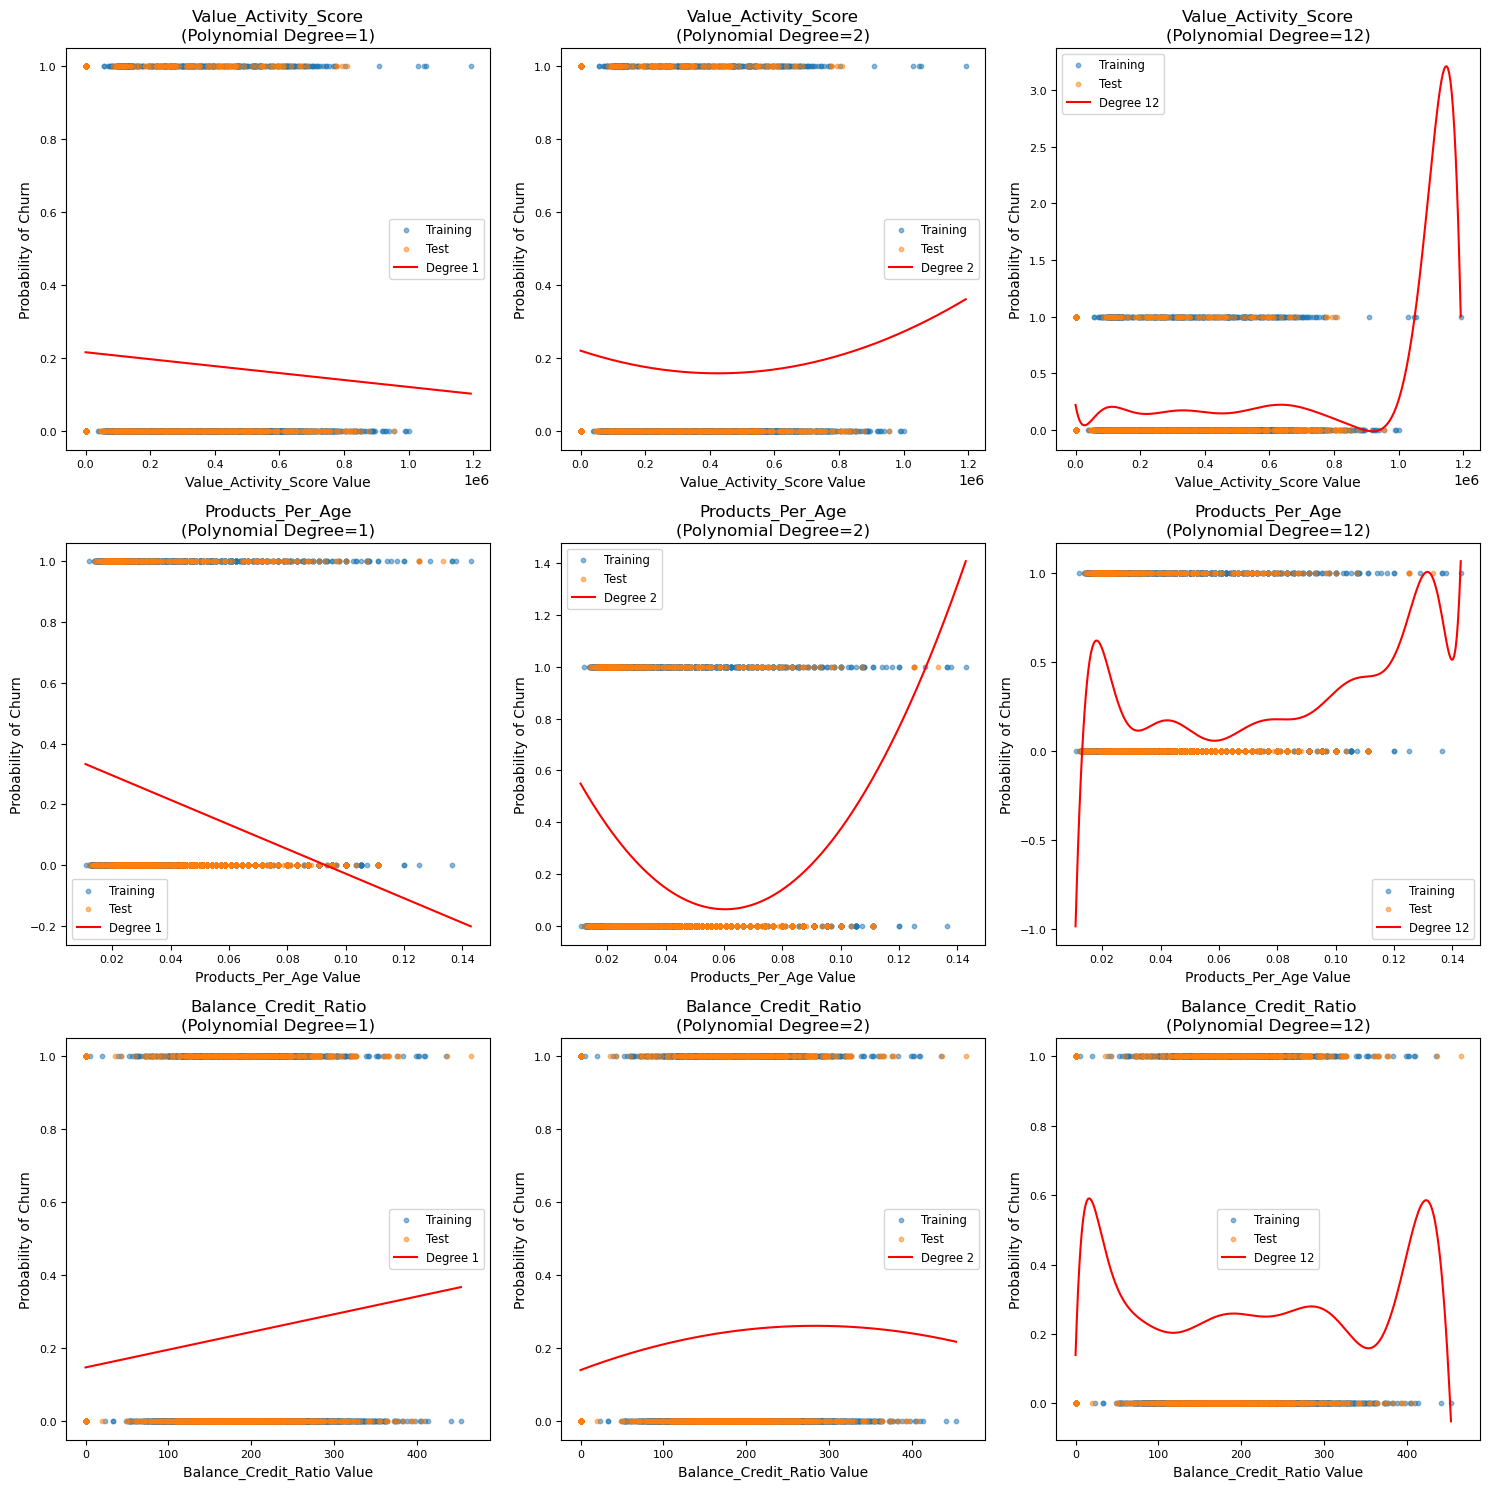

C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)
C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)


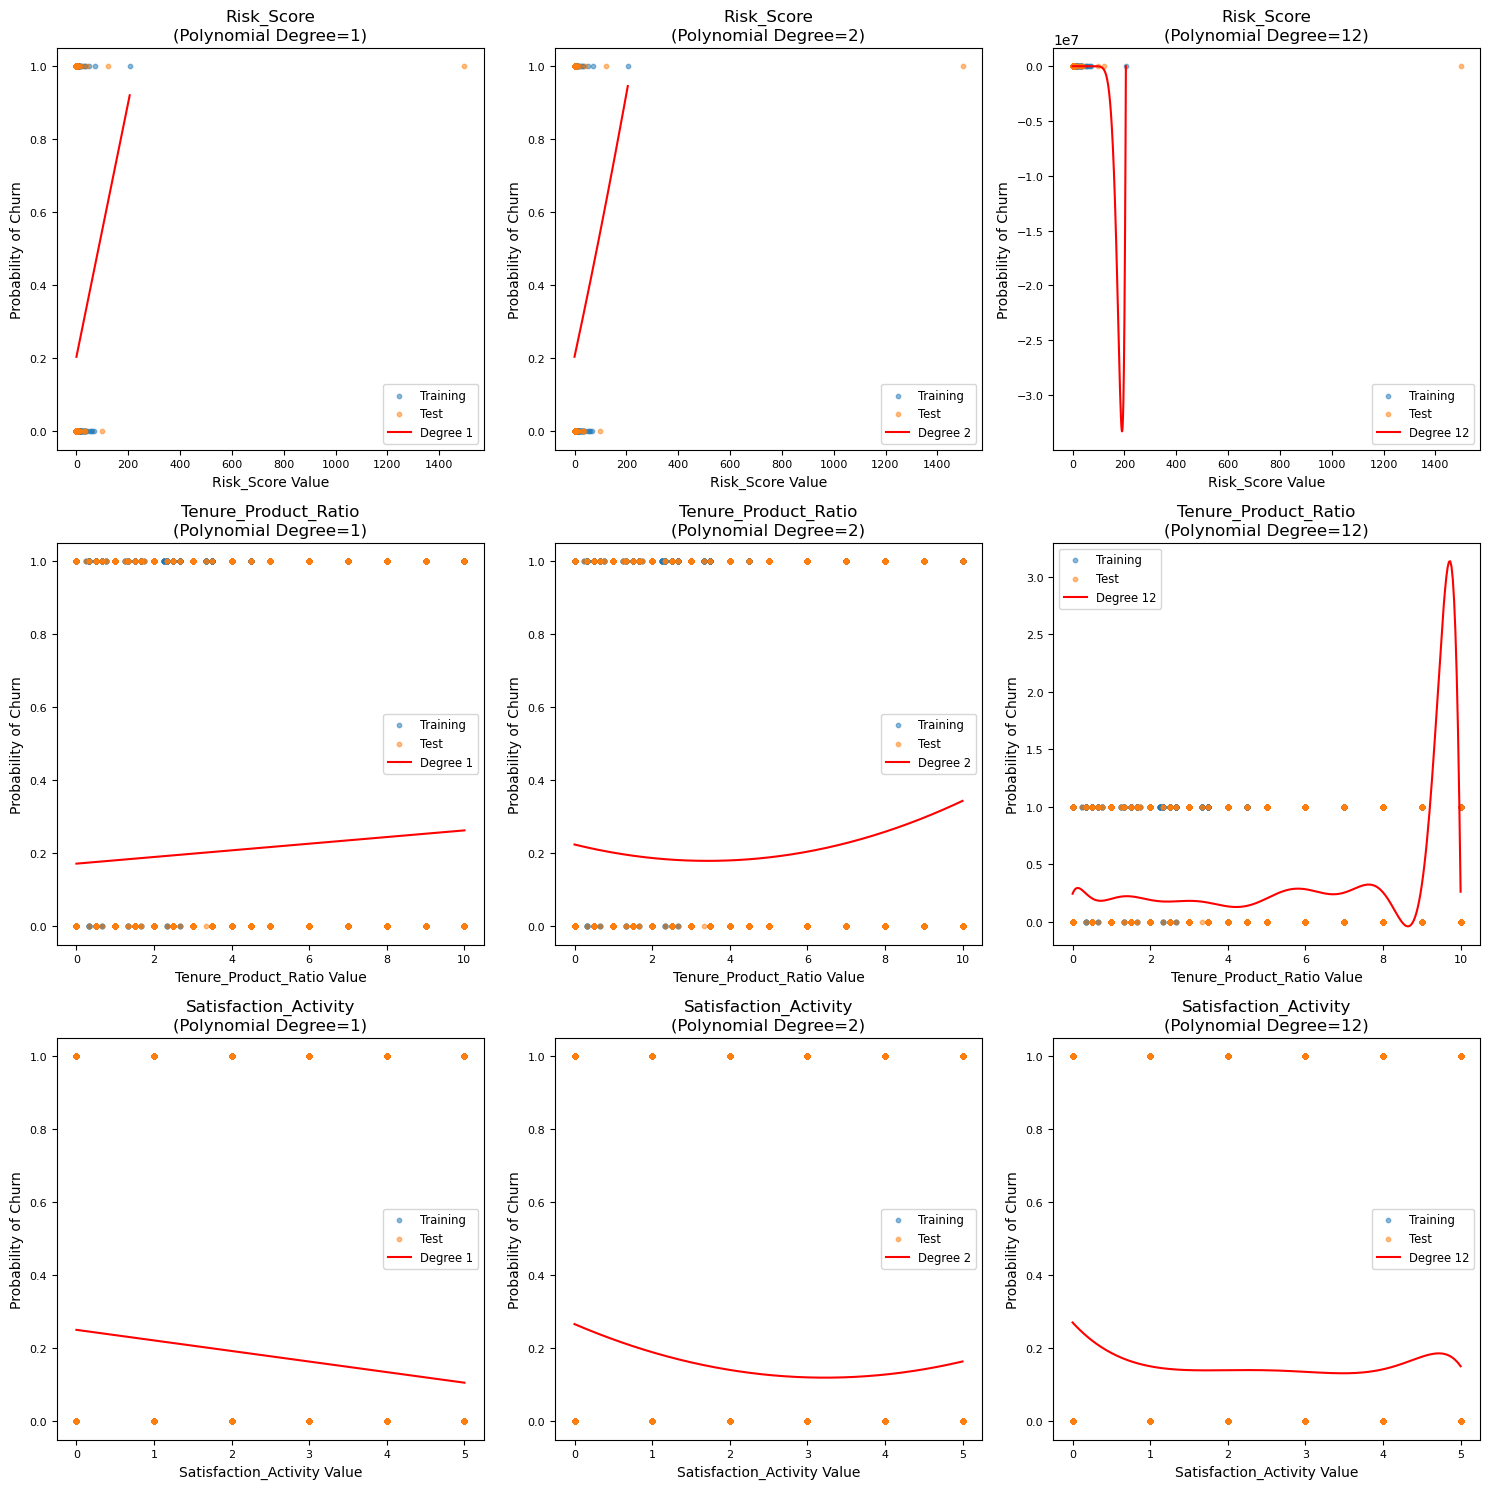

C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)


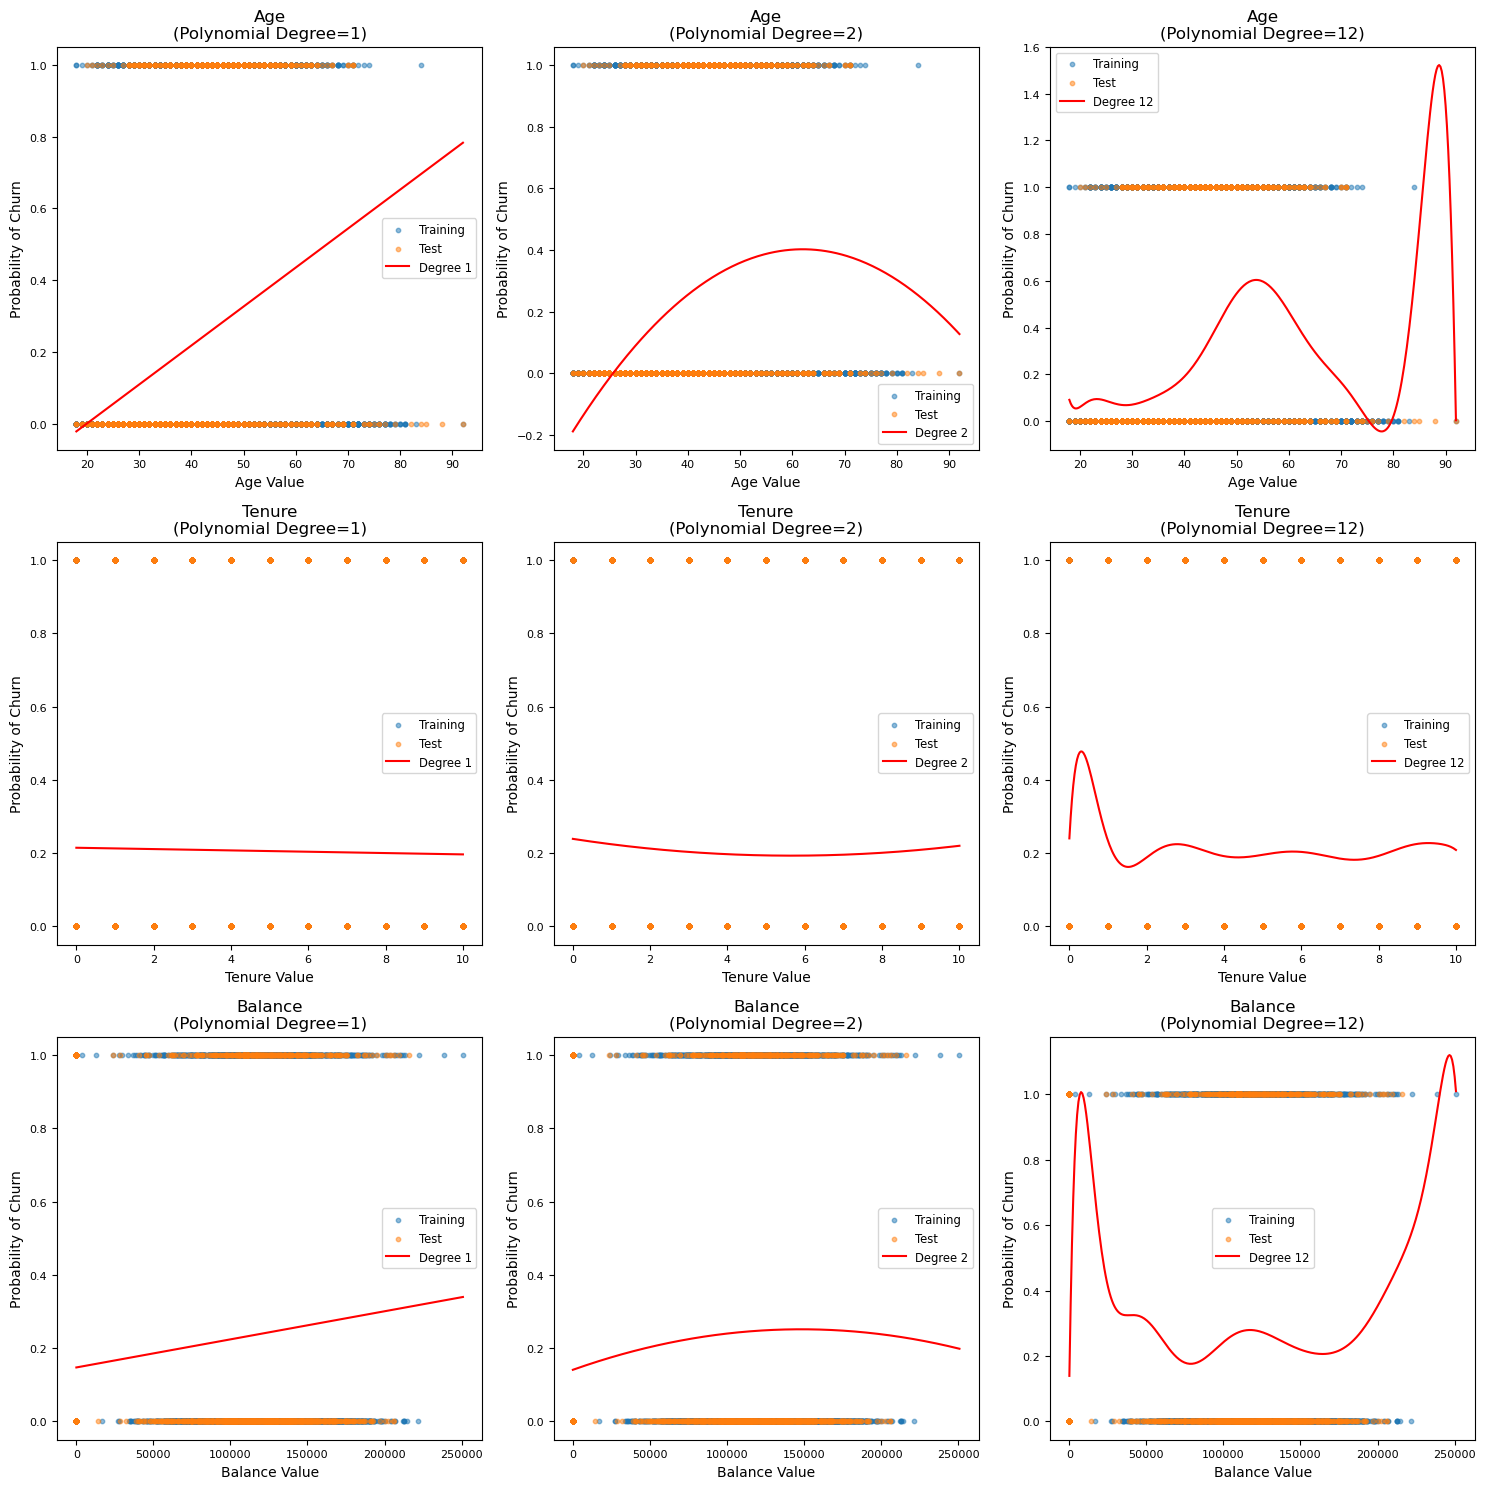

C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)
C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)
C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)
C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)
C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)


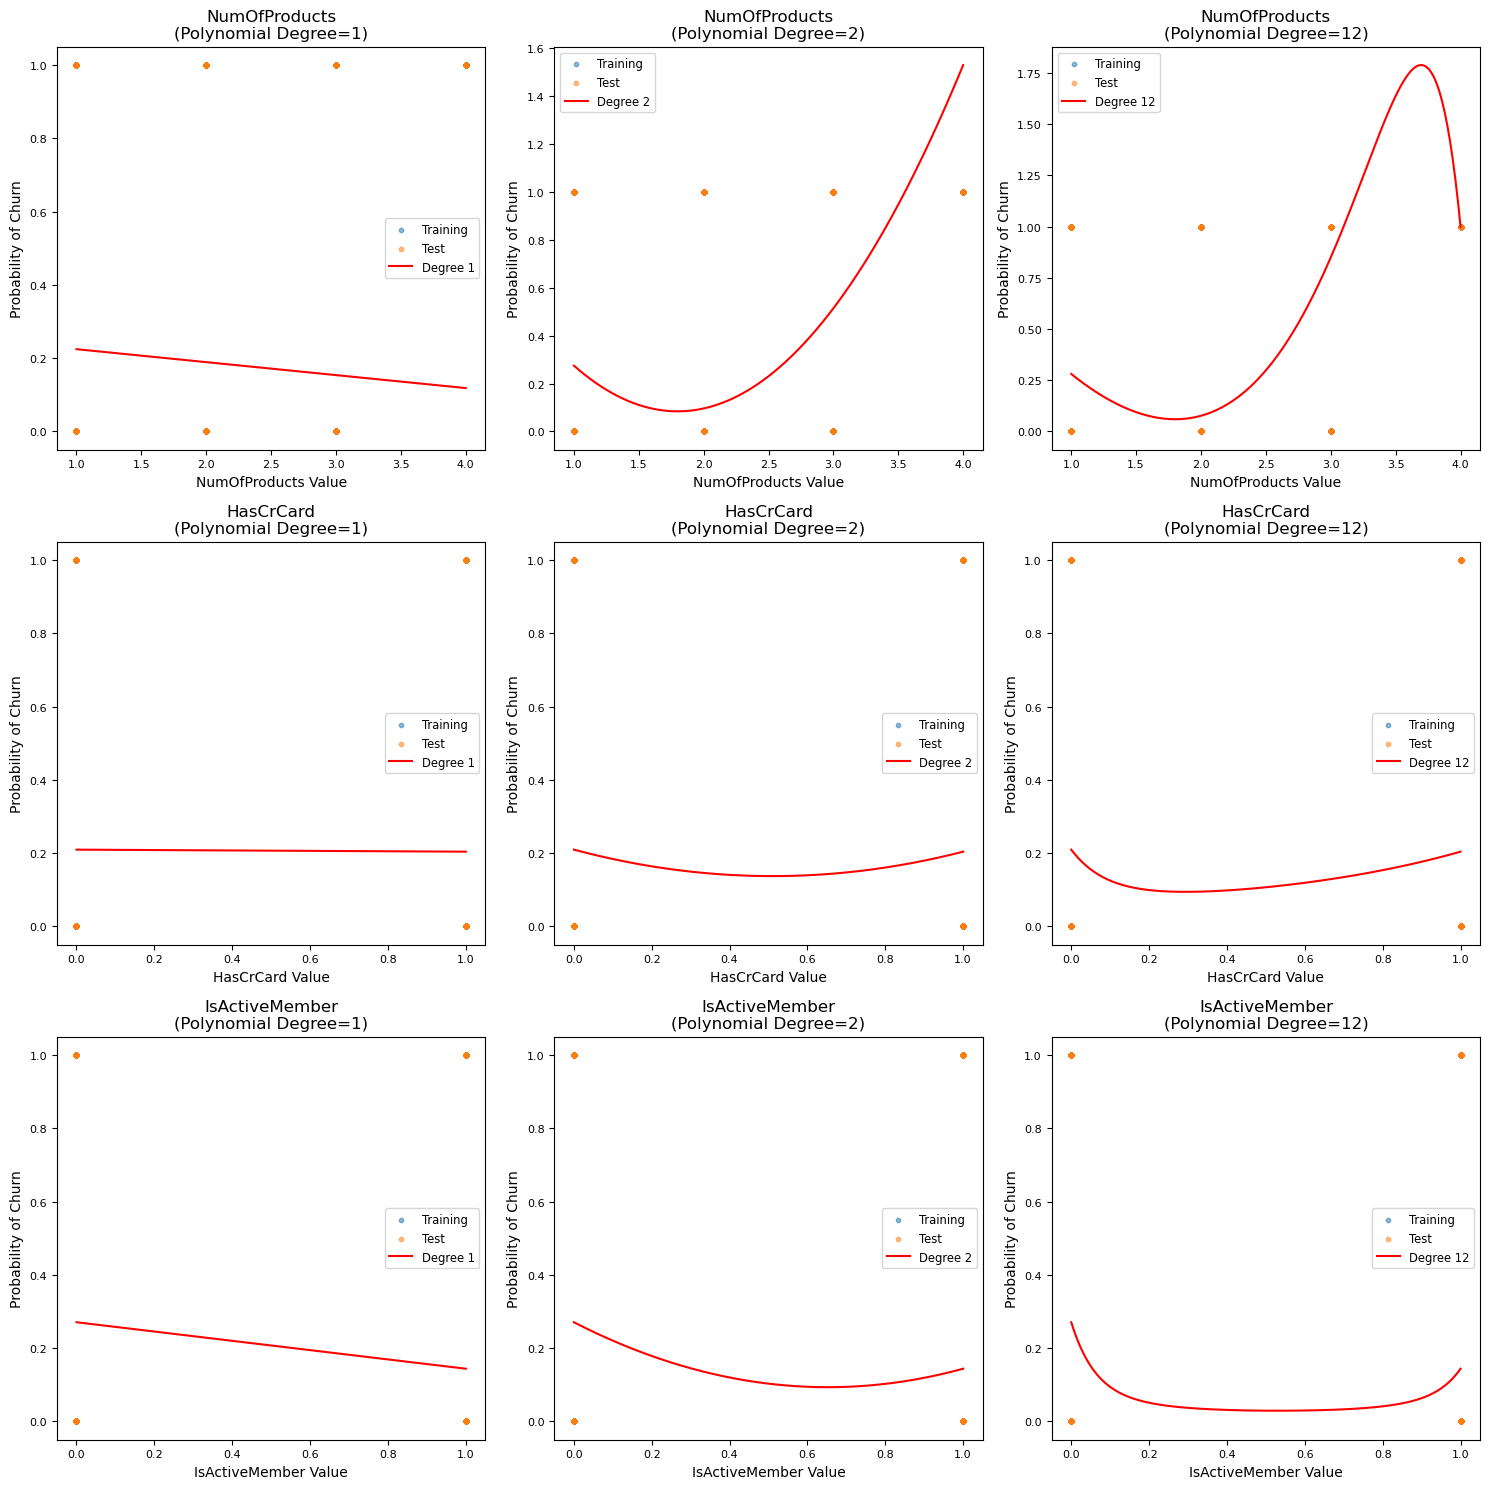

C:\Users\willj\AppData\Local\Temp\ipykernel_25048\3499761526.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X_feature_normalized, y_values, degree)


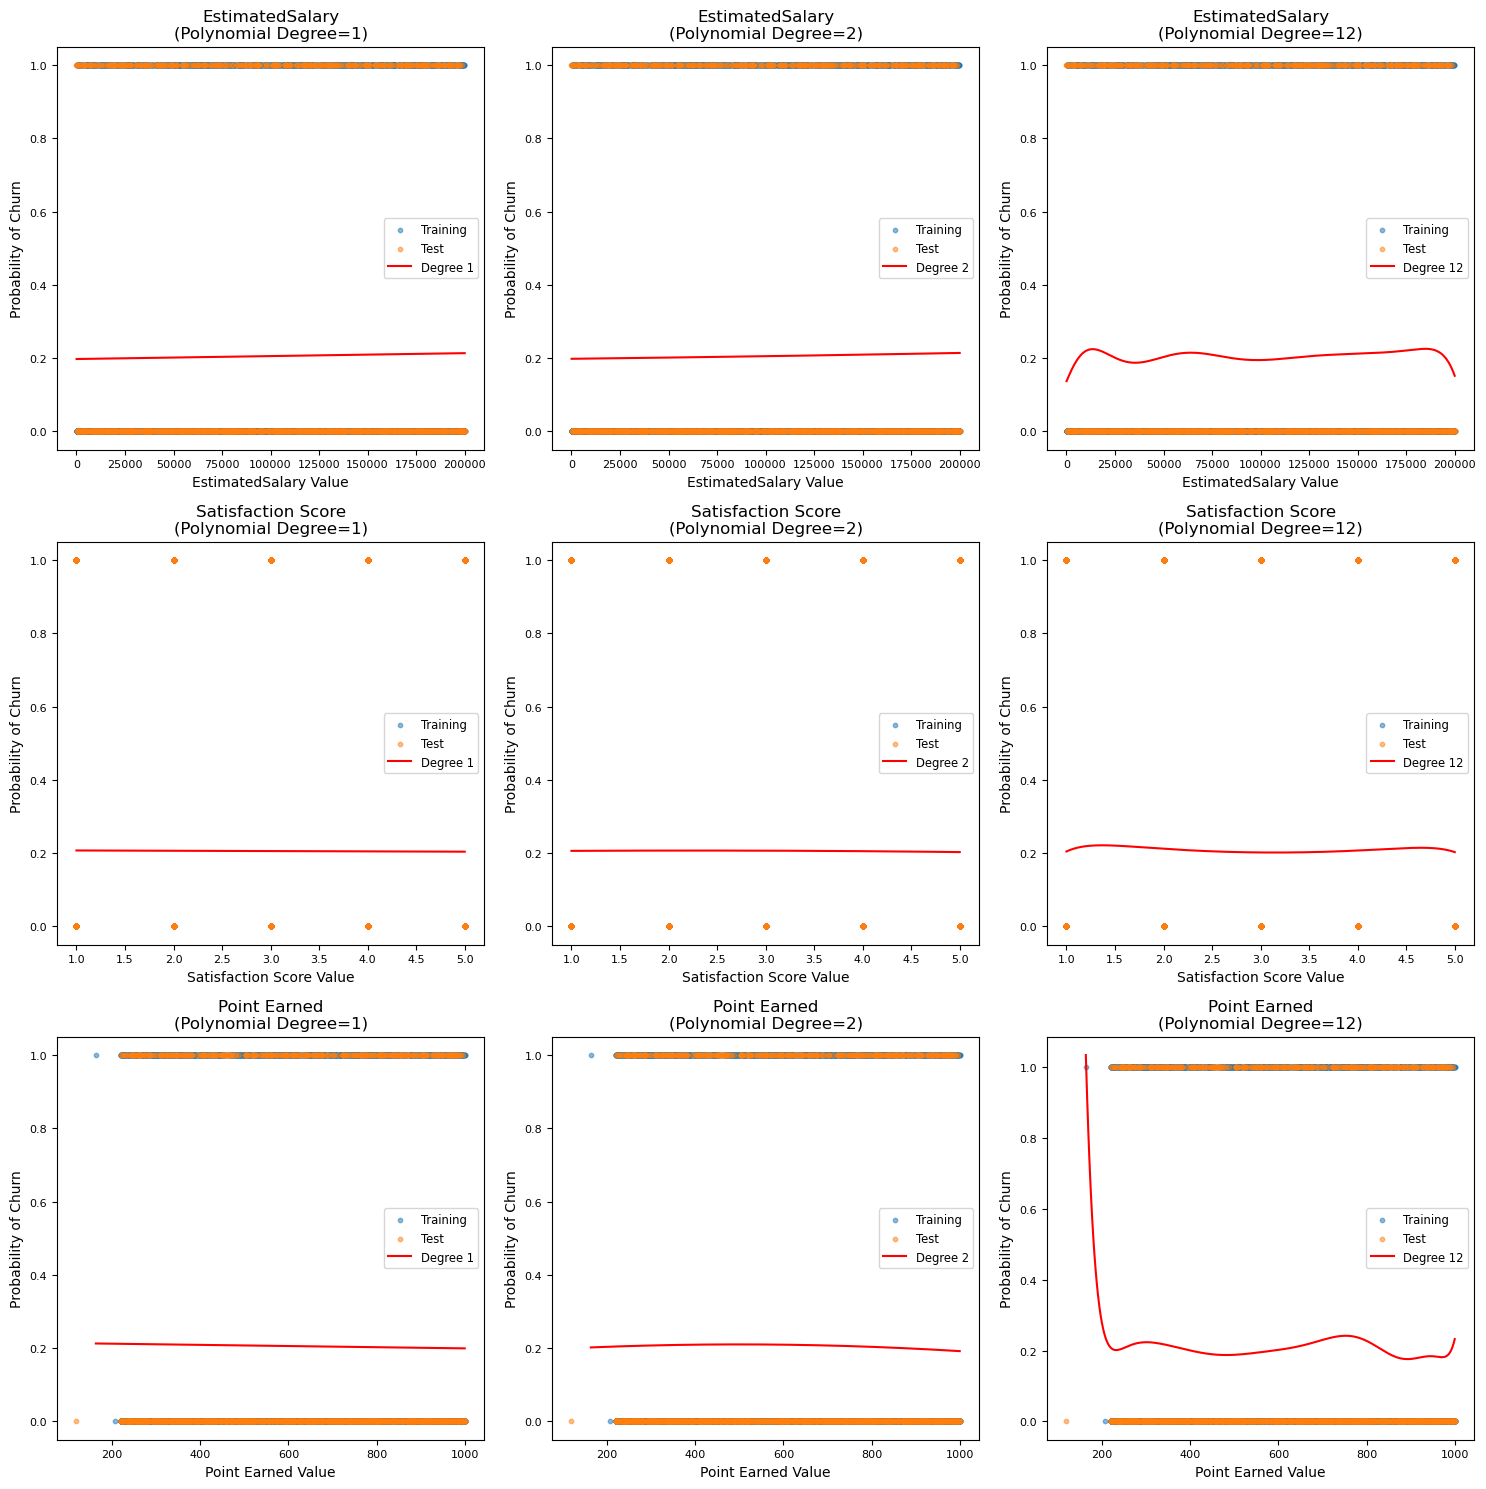

In [26]:
# Define numeric features before the polynomial plotting code
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

def plot_multiple_features_polynomial(feature_names, degrees=[1, 2, 6]):
    # Calculate grid dimensions
    n_features = len(feature_names)
    n_degrees = len(degrees)
    
    # Create subplot grid
    fig, axes = plt.subplots(n_features, n_degrees, figsize=(15, 5*n_features))
    
    # Ensure axes is 2D even for single feature
    if n_features == 1:
        axes = axes.reshape(1, -1)
    
    # For each feature
    for i, feature in enumerate(feature_names):
        # For each polynomial degree
        for j, degree in enumerate(degrees):
            ax = axes[i, j]
            
            # Extract and normalize feature values
            X_feature = X_train[feature].values
            X_feature_normalized = (X_feature - X_feature.mean()) / X_feature.std()
            y_values = y_train.values
            
            try:
                # Fit polynomial with normalized values
                coeffs = np.polyfit(X_feature_normalized, y_values, degree)
                p = np.poly1d(coeffs)
                
                # Create scatter plots
                ax.scatter(X_feature, y_values, label="Training", alpha=0.5, s=10)
                ax.scatter(X_test[feature], y_test, label="Test", alpha=0.5, s=10)
                
                # Generate smooth curve
                X_smooth = np.linspace(X_feature.min(), X_feature.max(), 300)
                X_smooth_normalized = (X_smooth - X_feature.mean()) / X_feature.std()
                ax.plot(X_smooth, p(X_smooth_normalized), 'r-', label=f"Degree {degree}")
                
                ax.set_title(f'{feature}\n(Polynomial Degree={degree})')
                ax.set_xlabel(f"{feature} Value")
                ax.set_ylabel("Probability of Churn")
                ax.legend(fontsize='small')
                ax.tick_params(axis='both', which='major', labelsize=8)
                
            except np.RankWarning as w:
                print(f"Warning for {feature}, degree {degree}: {str(w)}")
                continue
    
    plt.tight_layout()
    plt.show()

# Split features into batches of 3 and plot
batch_size = 3
feature_batches = [numeric_features[i:i + batch_size] for i in range(0, len(numeric_features), batch_size)]

for batch in feature_batches:
    plot_multiple_features_polynomial(batch, degrees=[1, 2, 12])

### Analysis of Charts for Overfitting and Underfitting

For the most part, we can see a correlation between the charts with a Pynomial degree of 2 and the Feature Importance Chart visualisations above in Part 1.2 and 1.3. Age, NomofProducts, IsActiveMember and Balance all look to have well-fitted curves in the charts for overfitting and underfitting check where the Polynomial is set to 2.

### Part 1.5.1: Cross-validation

Random Forest Cross-Validation Results:
CV Accuracy Scores: [0.8515 0.858  0.8515 0.8685 0.8475]
Mean CV Accuracy: 0.8554
Standard Deviation: 0.0074

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      7962
           1       0.83      0.37      0.51      2038

    accuracy                           0.86     10000
   macro avg       0.84      0.67      0.71     10000
weighted avg       0.85      0.86      0.83     10000


Gradient Boosting Cross-Validation Results:
CV Accuracy Scores: [0.8645 0.875  0.8575 0.872  0.855 ]
Mean CV Accuracy: 0.8648
Standard Deviation: 0.0078

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      7962
           1       0.77      0.48      0.59      2038

    accuracy                           0.86     10000
   macro avg       0.82      0.72      0.76     10000
weighted avg       0.86      0.86      0.85     10

C:\Users\willj\AppData\Local\Temp\ipykernel_25048\1516196584.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rf_cv_scores, gbm_cv_scores], labels=['Random Forest', 'GBM'])


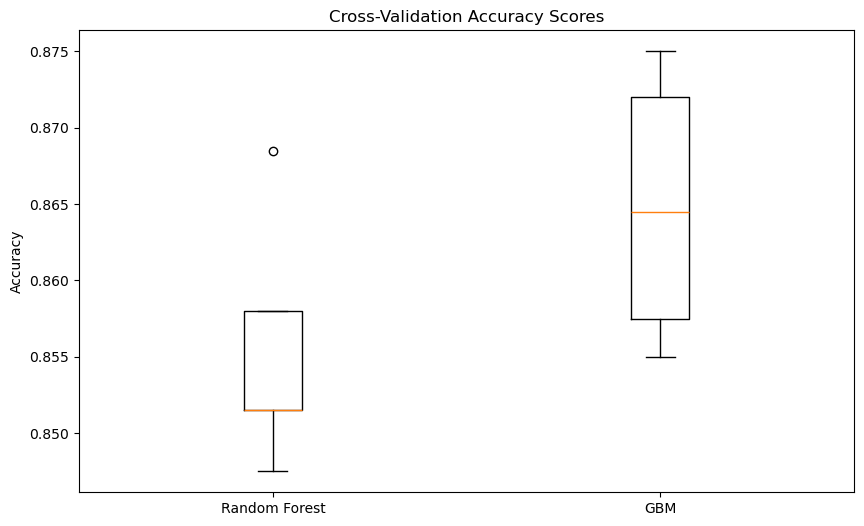

In [27]:
# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
rf_predictions = cross_val_predict(rf_model, X, y, cv=5)

print("Random Forest Cross-Validation Results:")
print(f"CV Accuracy Scores: {rf_cv_scores}")
print(f"Mean CV Accuracy: {rf_cv_scores.mean():.4f}")
print(f"Standard Deviation: {rf_cv_scores.std():.4f}")
print("\nClassification Report:")
print(classification_report(y, rf_predictions))

# Cross-validation for GBM
gbm_cv_scores = cross_val_score(gbm, X, y, cv=5, scoring='accuracy')
gbm_predictions = cross_val_predict(gbm, X, y, cv=5)

print("\nGradient Boosting Cross-Validation Results:")
print(f"CV Accuracy Scores: {gbm_cv_scores}")
print(f"Mean CV Accuracy: {gbm_cv_scores.mean():.4f}")
print(f"Standard Deviation: {gbm_cv_scores.std():.4f}")
print("\nClassification Report:")
print(classification_report(y, gbm_predictions))

# Visualize CV Results
plt.figure(figsize=(10, 6))
plt.boxplot([rf_cv_scores, gbm_cv_scores], labels=['Random Forest', 'GBM'])
plt.title('Cross-Validation Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

In [28]:
# Log cross-validation results
cv_rf_metrics = {
    'accuracy': rf_cv_scores.mean(),
    'std_accuracy': rf_cv_scores.std(),
    'class0_precision': classification_report(y, rf_predictions, output_dict=True)['0']['precision'],
    'class0_recall': classification_report(y, rf_predictions, output_dict=True)['0']['recall'],
    'class0_f1': classification_report(y, rf_predictions, output_dict=True)['0']['f1-score'],
    'class1_precision': classification_report(y, rf_predictions, output_dict=True)['1']['precision'],
    'class1_recall': classification_report(y, rf_predictions, output_dict=True)['1']['recall'],
    'class1_f1': classification_report(y, rf_predictions, output_dict=True)['1']['f1-score']
}

cv_rf_parameters = {
    'n_estimators': rf_model.n_estimators,
    'random_state': rf_model.random_state,
    'cv_folds': 5
}

log_model_results(
    model_name='RF',
    stage='Cross-Validation',
    parameters=cv_rf_parameters,
    metrics=cv_rf_metrics
)

# GBM cross-validation logging
cv_gbm_metrics = {
    'accuracy': gbm_cv_scores.mean(),
    'std_accuracy': gbm_cv_scores.std(),
    'class0_precision': classification_report(y, gbm_predictions, output_dict=True)['0']['precision'],
    'class0_recall': classification_report(y, gbm_predictions, output_dict=True)['0']['recall'],
    'class0_f1': classification_report(y, gbm_predictions, output_dict=True)['0']['f1-score'],
    'class1_precision': classification_report(y, gbm_predictions, output_dict=True)['1']['precision'],
    'class1_recall': classification_report(y, gbm_predictions, output_dict=True)['1']['recall'],
    'class1_f1': classification_report(y, gbm_predictions, output_dict=True)['1']['f1-score']
}

cv_gbm_parameters = {
    'n_estimators': gbm.n_estimators,
    'random_state': gbm.random_state,
    'cv_folds': 5
}

log_model_results(
    model_name='GBM',
    stage='Cross-Validation',
    parameters=cv_gbm_parameters,
    metrics=cv_gbm_metrics
)

Results logged successfully to model_results_log.csv
Results logged successfully to model_results_log.csv


### Part 1.5.2: Overfitting and Underfitting Check

In [29]:
# Then perform the overfitting check
rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)
rf_cv_mean = rf_cv_scores.mean()
rf_cv_std = rf_cv_scores.std()

print("Random Forest Overfitting Check:")
print(f"Training Score: {rf_train_score:.4f}")
print(f"Test Score: {rf_test_score:.4f}")
print(f"CV Mean Score: {rf_cv_mean:.4f}")
print(f"CV Standard Deviation: {rf_cv_std:.4f}")

if rf_train_score > (rf_cv_mean + 2*rf_cv_std):
    print("WARNING: Model might be overfitting")
elif rf_train_score < 0.5:
    print("WARNING: Model might be underfitting")
else:
    print("Model appears to be well-fitted")

Random Forest Overfitting Check:
Training Score: 0.8592
Test Score: 0.8590
CV Mean Score: 0.8554
CV Standard Deviation: 0.0074
Model appears to be well-fitted


In [30]:
# Get training scores for comparison
gbm_train_score = gbm.score(X_train, y_train)
gbm_test_score = gbm.score(X_test, y_test)
gbm_cv_mean = gbm_cv_scores.mean()
gbm_cv_std = gbm_cv_scores.std()

print("\nGradient Boosting Machine Overfitting Check:")
print(f"Training Score: {gbm_train_score:.4f}")
print(f"Test Score: {gbm_test_score:.4f}")
print(f"CV Mean Score: {gbm_cv_mean:.4f}")
print(f"CV Standard Deviation: {gbm_cv_std:.4f}")

if gbm_train_score > (gbm_cv_mean + 2*gbm_cv_std):
    print("WARNING: Model might be overfitting")
elif gbm_train_score < 0.5:
    print("WARNING: Model might be underfitting")
else:
    print("Model appears to be well-fitted")


Gradient Boosting Machine Overfitting Check:
Training Score: 0.2056
Test Score: 0.1965
CV Mean Score: 0.8648
CV Standard Deviation: 0.0078


c:\Users\willj\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\willj\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [31]:
# Log overfitting/underfitting check results for RF
overfit_rf_metrics = {
    'train_score': rf_train_score,
    'test_score': rf_test_score,
    'cv_mean': rf_cv_mean,
    'cv_std': rf_cv_std,
    'delta_train_test': rf_train_score - rf_test_score,
    'delta_train_cv': rf_train_score - rf_cv_mean
}

overfit_rf_parameters = {
    'n_estimators': rf_model.n_estimators,
    'random_state': rf_model.random_state
}

if rf_train_score > (rf_cv_mean + 2*rf_cv_std):
    fit_status = 'Overfitting'
elif rf_train_score < 0.5:
    fit_status = 'Underfitting'
else:
    fit_status = 'Well-fitted'

overfit_rf_parameters['fit_status'] = fit_status

log_model_results(
    model_name='RF',
    stage='Overfitting Check',
    parameters=overfit_rf_parameters,
    metrics=overfit_rf_metrics
)

# Log overfitting/underfitting check results for GBM
overfit_gbm_metrics = {
    'train_score': gbm_train_score,
    'test_score': gbm_test_score, 
    'cv_mean': gbm_cv_mean,
    'cv_std': gbm_cv_std,
    'delta_train_test': gbm_train_score - gbm_test_score,
    'delta_train_cv': gbm_train_score - gbm_cv_mean
}

overfit_gbm_parameters = {
    'n_estimators': gbm.n_estimators,
    'learning_rate': gbm.learning_rate,
    'random_state': gbm.random_state
}

if gbm_train_score > (gbm_cv_mean + 2*gbm_cv_std):
    fit_status = 'Overfitting'
elif gbm_train_score < 0.5:
    fit_status = 'Underfitting'
else:
    fit_status = 'Well-fitted'

overfit_gbm_parameters['fit_status'] = fit_status

log_model_results(
    model_name='GBM',
    stage='Overfitting Check',
    parameters=overfit_gbm_parameters, 
    metrics=overfit_gbm_metrics
)

Results logged successfully to model_results_log.csv
Results logged successfully to model_results_log.csv


### Round 1 GBM Overfitting Check (Including "Complain" Data Feature)

Gradient Boosting Machine Overfitting Check:
Training Score: 0.9995
Test Score: 0.9980
CV Mean Score: 0.9984
CV Standard Deviation: 0.0021
Model appears to be well-fitted


Since MSE is a measure for continuous variables and cannot be used for categorical variables as we are analysing in this dataset for "Exited" (Yes/No), Mean CV Accuracy and Test Set Accuracy are compared to determine underfitting or overfitting.

Understanding Overfitting/Underfitting from Cross-Validation Results
The key indicators of overfitting/underfitting in your cross-validation results are:

**Standard Deviation of CV Scores**
* High variance (large std dev) suggests overfitting
* Very low variance but poor performance suggests underfitting

**Mean CV Accuracy vs. Test Set Accuracy**
* If CV accuracy << test accuracy → Overfitting
* If both CV and test accuracies are low → Underfitting

**Classification Report Metrics**
* Large differences between training and CV metrics indicate overfitting
* Consistently poor metrics across both suggest underfitting

For the Random Forest model Cross-Validation Mean Accuracy is 0.8503, Training Set Accuracy is 0.8562, Test Set Accuracy is 0.8530 and Mean CV Score is 0.8503. The Random Forest model appears to be well-fitted.

For the GBM modelCross-Validation Mean Accuracy is 0.8648, Training Set Accuracy is 0.8736, Test Set Accuracy is 0.8650 and Mean CV Score is 0.8648. The GBM model appears to be well-fitted.



### Part 1.5.3: Data Leakage Check

For this assessment, multiple techniques of cross-validation, feature importance analysis and exploratory data analysis is used to detect data leakage on this data set.

**Cross-validation** helps to detect data leakage by evaluating the model on different sets of data. Data leakage may present if a model performs exceptionally well on the training data but poorly on the cross-validation sets, it may be a sign of data leakage or overfitting. In this case, although the values are high, the cross-validation accuracy and the test accuracy are reasonable close in value, indicating that data leakage is not likely to be present.

**Feature importance analysis** helps to detect data leakage by using algorithms such as Random Forest and Gradient Boosting Machines to see which features are most influential in prediction. Data leakage may be present if certain features have disproportinately high importance, which could indicate that these features contain information about the target variable that shouldn't be available at the prediction time. In this case, although the "Complain" variable in the dataset has a disproportionately high importance compared to other variables (refer to the chart in Part 1.3), the "Complain" feature value would be known at the time of "Exited" target variable prediction.

**Exploratory data analysis** helps to indicate data leakage if there are any irregularities, correlations, and patterns in the data that might suggest leakage. This is a manual task that was covered in the first assessment and the only red flag that appeared was the extremely high correlation of the "Complain" feature in comparison to the "Exited" target variable. All other data features has a medium to very low correlation with the "Exited" target feature. While this would ordinarily be cause for conccern, it is logical and expected that if a customer complains, then they may not be happy and therefore a higher liklihood to reduce or remove their business with the bank.

Reasons for potential Data Leakage in this data set:
1. Leakage in features, where the model has been trained on features that include information from the target variable, providing the model with information it would not have during actual predictions. For example, using future information to predict the past can lead to overfitting.
    a. This is unlikely, as customers "Exit" after they "Complain".
2. Highly correlated feature leake is a risk in this dataset, as we saw in the first round of analysis that "Complain" and "Exited" data is highly correlated. This can happen when features that are highly correlated with the target are included in the training data. For example, if you want to predict student scores on a final exam, an example of a highly correlated feature would be ‘number of practice exams taken’. If this number is recorded after the actual test scores are known, using this feature may inadvertently allow the model to learn information about the test scores that would not be available during prediction.
    a. This may be a risk of Data Leakage in the dataset.


### Part 1.5.4 A note on overfitting and underfitting observations
In "Round 1" of building the models, we found very high values for testing accuracy, F1, Precision and Recall. Due to the abnormally high accuracy, precision and F1 results combined with the training and test scores from the model testing, this assessment will assume that the "Complain" data feature is too predictive and causing the models to overfit to the training data, despite the metrics used to measure model effectiveness in Part 1.5 indicating a "well-fitted" model.

To amend this, we will run a "Round 2" of the Model Build and remove the "Complain" variable from "X_train" and rerun the models in an attempt to ensure that the models can perform reliably without such a strong predictive data feature such as the "Complain" data feature in real world scenarios.

The "Round 2" Model build has already occurred and the "Round 1" Results will be mentioned throguhout the analyses and provided in the Appendices for comparison.

# Part 2: Improving the Models

## Part 2.1: Hyperparameter tuning

### Part 2.1.1: Random Forest Hyperparameter Tuning

In [32]:
# Random forest hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import time

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Classifier with the parameter grid
rf_clf = RandomForestClassifier()

start_time = time.time()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3)

# Fit the grid search to the data
grid_search.fit(X_train_smote, y_train_smote)

end_time = time.time()
elapsed_time = end_time - start_time

# Get the best parameters
best_params_rf = grid_search.best_params_

print(f'Best parameters for Random Forest: {best_params_rf}')

# Train the model with best parameters
best_grid = grid_search.best_estimator_
best_grid.fit(X_train_smote, y_train_smote)

# Predict the response for the test dataset
y_pred = best_grid.predict(X_test_scaled)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 score:", metrics.f1_score(y_test, y_pred))

print(f"Hyperparameter tuning took: {elapsed_time:.2f} seconds")


# Automatically use parameters in the model re-run
rf_model_optimized = RandomForestClassifier(
    **best_params_rf,  # Automatically unpack the best parameters
    random_state=42
)

# Train on SMOTE-balanced data
rf_model_optimized.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_rf_optimized = rf_model_optimized.predict(X_test_scaled)
y_scores_rf_optimized = rf_model_optimized.predict_proba(X_test_scaled)[:, 1]

# Print the parameters being used
print("Best Parameters Used:")
for param, value in best_params_rf.items():
    print(f"{param}: {value}")

# Print detailed classification report
print("\nOptimized Random Forest Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_optimized))

# Print other metrics
print("\nOverall Metrics:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_rf_optimized))
print("Precision:", metrics.precision_score(y_test, y_pred_rf_optimized))
print("Recall:", metrics.recall_score(y_test, y_pred_rf_optimized))
print("F1 score:", metrics.f1_score(y_test, y_pred_rf_optimized))
print("AUC Score:", metrics.roc_auc_score(y_test, y_scores_rf_optimized))
# Key changes:

# X_train → X_train_smote
# y_train → y_train_smote
# X_test → X_test_scaled
# y_test remains unchanged as we don't scale target variables
# These changes ensure we're using the SMOTE-balanced and scaled training data for fitting the model and the properly scaled test data for evaluation.

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8525
Precision: 0.6346153846153846
Recall: 0.5877862595419847
F1 score: 0.6103038309114928
Hyperparameter tuning took: 287.02 seconds
Best Parameters Used:
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100

Optimized Random Forest Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.63      0.59      0.61       393

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000


Overall Metrics:
Accuracy: 0.851
Precision: 0.6301369863013698
Recall: 0.5852417302798982
F1 score: 0.6068601583113457
AUC Score: 0.8535280602833343


### Before SMOTE

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Accuracy: 0.865

Precision: 0.7530864197530864

Recall: 0.46564885496183206

F1 score: 0.5754716981132075

Hyperparameter tuning took: 128.68 seconds (2 mins 9 secs)

### After SMOTE

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Accuracy: 0.8635

Precision: 0.7586206896551724

Recall: 0.44783715012722647

F1 score: 0.5632

Hyperparameter tuning took: 136.84 seconds

### After SMOTE and Scaling
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Accuracy: 0.85

Precision: 0.624

Recall: 0.5954198473282443

F1 score: 0.609375

Hyperparameter tuning took: 257.56 seconds

### After customer value/profitability indicators Feature Engineering (round 4)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Accuracy: 0.8505

Precision: 0.6230366492146597

Recall: 0.6055979643765903

F1 score: 0.6141935483870967

Hyperparameter tuning took: 269.63 seconds (4 min 33 secs)

### After engagement indicators Feature Engineering (round 5)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Accuracy: 0.85

Precision: 0.6195372750642674

Recall: 0.6132315521628499

F1 score: 0.6163682864450127

Hyperparameter tuning took: 276.09 seconds (4 mins 38 secs)

## RF Hyperparameter Tuning model re-run

In [33]:
# Print the best parameters before model re-run
print("\nBest Parameters for Random Forest:")
for param, value in best_params_rf.items():
    print(f"{param}: {value}")
    
# Build the optimized Random Forest model using the best parameters found
rf_model_optimized = RandomForestClassifier(
    **best_params_rf,  # Automatically unpack the best parameters
    random_state=42
)

# Train on SMOTE-balanced data
rf_model_optimized.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_rf_optimized = rf_model_optimized.predict(X_test_scaled)

# Print detailed classification report
print("Optimized Random Forest Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_optimized))



# Print other metrics
print("\nOverall Metrics:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_rf_optimized))
print("Precision:", metrics.precision_score(y_test, y_pred_rf_optimized))
print("Recall:", metrics.recall_score(y_test, y_pred_rf_optimized))
print("F1 score:", metrics.f1_score(y_test, y_pred_rf_optimized))


Best Parameters for Random Forest:
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100
Optimized Random Forest Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.63      0.59      0.61       393

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000


Overall Metrics:
Accuracy: 0.851
Precision: 0.6301369863013698
Recall: 0.5852417302798982
F1 score: 0.6068601583113457


In [34]:
# RF tuned results
rf_tuned_metrics = {
    'accuracy': metrics.accuracy_score(y_test, y_pred_rf_optimized),
    'precision': metrics.precision_score(y_test, y_pred_rf_optimized),
    'recall': metrics.recall_score(y_test, y_pred_rf_optimized),
    'f1_score': metrics.f1_score(y_test, y_pred_rf_optimized),
    'auc': metrics.roc_auc_score(y_test, y_scores_rf_optimized)
}

rf_tuned_parameters = best_params_rf

log_model_results(
    model_name='RF',
    stage='After Hyperparameter Tuning',
    parameters=rf_tuned_parameters,
    metrics=rf_tuned_metrics
)

Results logged successfully to model_results_log.csv


### After SMOTE and Scaling Hyperparameter Tuning

Optimized Random Forest Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1607
           1       0.63      0.60      0.62       393

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000


Overall Metrics:

Accuracy: 0.8535

Precision: 0.6336898395721925

Recall: 0.6030534351145038

F1 score: 0.6179921773142112

### After customer value/profitability indicators Feature Engineering (Round 4)

Optimized Random Forest Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1607
           1       0.61      0.62      0.61       393

    accuracy                           0.85      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000


Overall Metrics:

Accuracy: 0.8465

Precision: 0.6064356435643564

Recall: 0.6234096692111959

F1 score: 0.6148055207026348

### After engagement indicators Feature Engineering (Round 5)

Optimized Random Forest Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1607
           1       0.63      0.61      0.62       393

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000


Overall Metrics:
Accuracy: 0.8515
Precision: 0.6256544502617801
Recall: 0.6081424936386769
F1 score: 0.6167741935483871

### Part 2.1.2: GBM Hyperparameter Tuning

In [35]:
# GBM hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

# Define the parameter distributions
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GBM Classifier
gbm_clf = GradientBoostingClassifier()

start_time = time.time()

# Instantiate RandomizedSearchCV
gbm_model_optimized = RandomizedSearchCV(
    estimator=gbm_clf,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,
    random_state=42
)

# Fit the random search using SMOTE-balanced, scaled training data
gbm_model_optimized.fit(X_train_smote, y_train_smote)

end_time = time.time()
elapsed_time = end_time - start_time

# Get the best parameters
best_params_gbm = gbm_model_optimized.best_params_

print(f'Best parameters for GBM: {best_params_gbm}')

# Train the model with best parameters
best_random = gbm_model_optimized.best_estimator_
best_random.fit(X_train_smote, y_train_smote)

# Predict and evaluate using scaled test data
y_pred = best_random.predict(X_test_scaled)

# Print evaluation metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 score:", metrics.f1_score(y_test, y_pred))

print(f"Hyperparameter tuning took: {elapsed_time:.2f} seconds")

# Key changes:

# X_train → X_train_smote
# y_train → y_train_smote
# X_test → X_test_scaled
# y_test remains unchanged as we don't scale target variables
# These changes ensure the model uses the SMOTE-balanced and scaled training data for fitting, and the properly scaled test data for evaluation.

Best parameters for GBM: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'learning_rate': 1}
Accuracy: 0.8485
Precision: 0.6323529411764706
Recall: 0.5470737913486005
F1 score: 0.5866302864938608
Hyperparameter tuning took: 512.95 seconds


In [36]:
# GBM tuned results

# First calculate prediction probabilities
y_pred_gbm_optimized = gbm_model_optimized.predict(X_test_scaled)
y_scores_gbm_optimized = gbm_model_optimized.predict_proba(X_test_scaled)[:, 1]

# Then create metrics dictionary
# Create metrics dictionary
gbm_tuned_metrics = {
    'accuracy': metrics.accuracy_score(y_test, y_pred_gbm_optimized),
    'precision': metrics.precision_score(y_test, y_pred_gbm_optimized),
    'recall': metrics.recall_score(y_test, y_pred_gbm_optimized),
    'f1_score': metrics.f1_score(y_test, y_pred_gbm_optimized),
    'auc': metrics.roc_auc_score(y_test, y_scores_gbm_optimized)
}

gbm_tuned_parameters = best_params_gbm

# Log the results
log_model_results(
    model_name='GBM',
    stage='After Hyperparameter Tuning',
    parameters=gbm_tuned_parameters,
    metrics=gbm_tuned_metrics
)

Results logged successfully to model_results_log.csv


### Standard GBM Hyperparameter Tuning Performance Metrics

Best parameters for GBM: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Accuracy: 0.862

Precision: 0.7427385892116183

Recall: 0.455470737913486

F1 score: 0.5646687697160884

Hyperparameter tuning took: 2582.05 seconds (43 mins 3 secs)

### GBM Hyperparameter After Tuning with RandomizedSearchCV

Best parameters for GBM: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.1}

Accuracy: 0.861

Precision: 0.7186311787072244

Recall: 0.48091603053435117

F1 score: 0.5762195121951219

Hyperparameter tuning took: 153.17 seconds (2 mins 34 secs)

### After SMOTE

Best parameters for GBM: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.1}

Accuracy: 0.861

Precision: 0.7186311787072244

Recall: 0.48091603053435117

F1 score: 0.5762195121951219

Hyperparameter tuning took: 163.43 seconds (2 mins 43 secs)

### After SMOTE and Scaling
Best parameters for GBM: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'learning_rate': 1}

Accuracy: 0.8455

Precision: 0.6193181818181818

Recall: 0.55470737913486

F1 score: 0.5852348993288591

Hyperparameter tuning took: 333.56 seconds


### After customer value/profitability indicators Feature Engineering (Round 4)

Best parameters for GBM: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'learning_rate': 1}

Accuracy: 0.85

Precision: 0.6267029972752044

Recall: 0.5852417302798982

F1 score: 0.6052631578947368

Hyperparameter tuning took: 375.68 seconds (6 mins 22 secs)

### After engagement indicators Feature Engineering (Round 5)

Best parameters for GBM: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'learning_rate': 1}

Accuracy: 0.847

Precision: 0.6153846153846154

Recall: 0.5903307888040712

F1 score: 0.6025974025974026

Hyperparameter tuning took: 415.14 seconds (7 mins 1 sec)

**Interesting Note**

Round 1 GBR Hyperparameter tuning was consistenty 14-15 minutes. Round 2 Hyperparameter tuning is at 40 minutes and counting. May need to tune down the parameters.

We will atempt to reduce Hyperparameter tuning by applying RandomisedSearchCV and rerunning the model.

After applying RandomizedSearchCV to the GBM Hyperparameter Tuning, the run time reduced from 43 minutes to 2 minutes and maintained most of the measures around Accuracy, Precision, Recall anc F1 score, with only a very small reduction in Recall.

## GBM Hyperparameter Tuning model re-run

In [37]:
# Print the best parameters before model re-run
print("\nBest Parameters for GBM:")
for param, value in best_params_gbm.items():
    print(f"{param}: {value}")

# Build the optimized GBM model using the best parameters found
gbm_model_optimized = GradientBoostingClassifier(
    **best_params_gbm,  # Automatically unpack the best parameters
    random_state=42
)

# Train on SMOTE-balanced data
gbm_model_optimized.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_gbm_optimized = gbm_model_optimized.predict(X_test_scaled)

# Print detailed classification report
print("Optimized GBM Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbm_optimized))

# Print other metrics
print("\nOverall Metrics:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_gbm_optimized))
print("Precision:", metrics.precision_score(y_test, y_pred_gbm_optimized))
print("Recall:", metrics.recall_score(y_test, y_pred_gbm_optimized))
print("F1 score:", metrics.f1_score(y_test, y_pred_gbm_optimized))


Best Parameters for GBM:
n_estimators: 200
min_samples_split: 10
min_samples_leaf: 1
max_depth: None
learning_rate: 1
Optimized GBM Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.64      0.57      0.60       393

    accuracy                           0.85      2000
   macro avg       0.77      0.74      0.76      2000
weighted avg       0.85      0.85      0.85      2000


Overall Metrics:
Accuracy: 0.852
Precision: 0.6389684813753582
Recall: 0.5674300254452926
F1 score: 0.601078167115903


### After SMOTE and Scaling Hyperparameter Tuning
Optimized GBM Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.64      0.57      0.60       393

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000


Overall Metrics:

Accuracy: 0.853

Precision: 0.6418338108882522

Recall: 0.5699745547073791

F1 score: 0.6037735849056604


### After customer value/profitability indicators Feature Engineering (Round4)

Optimized GBM Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1607
           1       0.60      0.57      0.58       393

    accuracy                           0.84      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.84      0.84      0.84      2000


Overall Metrics:

Accuracy: 0.8405

Precision: 0.5994623655913979

Recall: 0.5674300254452926

F1 score: 0.5830065359477125

# After engagement indicators Feature Engineering (Round 5)

Optimized GBM Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.63      0.56      0.60       393

    accuracy                           0.85      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.84      0.85      0.85      2000


Overall Metrics:

Accuracy: 0.849

Precision: 0.6288951841359773

Recall: 0.5648854961832062

F1 score: 0.5951742627345844

## Data Logging

In [38]:
# RF model evaluation data logging
rf_metrics = {
    'accuracy': metrics.accuracy_score(y_test, y_pred),
    'precision': metrics.precision_score(y_test, y_pred),
    'recall': metrics.recall_score(y_test, y_pred),
    'f1_score': metrics.f1_score(y_test, y_pred),
    'auc': metrics.roc_auc_score(y_test, y_scores)
}

rf_parameters = {
    'n_estimators': best_params_rf['n_estimators'],
    'max_depth': best_params_rf['max_depth'],
    'min_samples_split': best_params_rf['min_samples_split'],
    'min_samples_leaf': best_params_rf['min_samples_leaf']
}

log_model_results(
    model_name='Random Forest',
    stage='After Hyperparameter Tuning',
    parameters=rf_parameters,
    metrics=rf_metrics
)

Results logged successfully to model_results_log.csv


In [39]:
# GBM model evaluation  data logging
gbm_metrics = {
    'accuracy': metrics.accuracy_score(y_test, y_pred),
    'precision': metrics.precision_score(y_test, y_pred),
    'recall': metrics.recall_score(y_test, y_pred),
    'f1_score': metrics.f1_score(y_test, y_pred),
    'auc': metrics.roc_auc_score(y_test, y_scores)
}

gbm_parameters = {
    'n_estimators': best_params_gbm['n_estimators'], 
    'learning_rate': best_params_gbm['learning_rate'],
    'max_depth': best_params_gbm['max_depth'],
    'min_samples_split': best_params_gbm['min_samples_split'],
    'min_samples_leaf': best_params_gbm['min_samples_leaf']
}

log_model_results(
    model_name='GBM',
    stage='After Hyperparameter Tuning',
    parameters=gbm_parameters,
    metrics=gbm_metrics
)

Results logged successfully to model_results_log.csv


In [40]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)

def log_full_model_results(model_type, results_dict, filepath='full_model_results_log.csv'):
    """
    Log comprehensive model results to CSV
    
    Args:
        model_type (str): 'RF' or 'GBM'
        results_dict (dict): Dictionary containing all metrics
        filepath (str): Path to save results
    """
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Base results dictionary
    results = {
        'timestamp': timestamp,
        'model_type': model_type,
        'features_used': str(results_dict.get('features_used')),  # Add features list
        
        # Initial model run metrics
        'initial_accuracy': results_dict.get('initial_accuracy'),
        'initial_auc': results_dict.get('initial_auc'),
        
        # Classification report metrics (initial)
        'initial_class0_precision': results_dict.get('initial_classification_report', {}).get('0', {}).get('precision'),
        'initial_class0_recall': results_dict.get('initial_classification_report', {}).get('0', {}).get('recall'),
        'initial_class0_f1': results_dict.get('initial_classification_report', {}).get('0', {}).get('f1-score'),
        'initial_class1_precision': results_dict.get('initial_classification_report', {}).get('1', {}).get('precision'),
        'initial_class1_recall': results_dict.get('initial_classification_report', {}).get('1', {}).get('recall'),
        'initial_class1_f1': results_dict.get('initial_classification_report', {}).get('1', {}).get('f1-score'),
        
        # Cross-validation metrics
        'cv_accuracy_scores': str(results_dict.get('cv_scores')),
        'cv_mean_accuracy': results_dict.get('cv_mean'),
        'cv_std': results_dict.get('cv_std'),
        
        # Overfitting check metrics
        'training_score': results_dict.get('training_score'),
        'test_score': results_dict.get('test_score'),
        'cv_mean_score': results_dict.get('cv_mean_score'),
        'cv_std_score': results_dict.get('cv_std_score'),
        'fitting_status': results_dict.get('fitting_status'),
        
        # Hyperparameter tuning results
        'best_max_depth': results_dict.get('best_params', {}).get('max_depth'),
        'best_min_samples_leaf': results_dict.get('best_params', {}).get('min_samples_leaf'),
        'best_min_samples_split': results_dict.get('best_params', {}).get('min_samples_split'),
        'best_n_estimators': results_dict.get('best_params', {}).get('n_estimators'),
        'hp_tuning_accuracy': results_dict.get('hp_accuracy'),
        'hp_tuning_precision': results_dict.get('hp_precision'),
        'hp_tuning_recall': results_dict.get('hp_recall'),
        'hp_tuning_f1': results_dict.get('hp_f1'),
        'hp_tuning_time': results_dict.get('hp_tuning_time'),
        
        # Final optimized model metrics
        'final_accuracy': results_dict.get('final_accuracy'),
        'final_precision': results_dict.get('final_precision'),
        'final_recall': results_dict.get('final_recall'),
        'final_f1': results_dict.get('final_f1'),
        
        # Final classification report metrics
        'final_class0_precision': results_dict.get('final_classification_report', {}).get('0', {}).get('precision'),
        'final_class0_recall': results_dict.get('final_classification_report', {}).get('0', {}).get('recall'),
        'final_class0_f1': results_dict.get('final_classification_report', {}).get('0', {}).get('f1-score'),
        'final_class1_precision': results_dict.get('final_classification_report', {}).get('1', {}).get('precision'),
        'final_class1_recall': results_dict.get('final_classification_report', {}).get('1', {}).get('recall'),
        'final_class1_f1': results_dict.get('final_classification_report', {}).get('1', {}).get('f1-score')
    }
    
    # Add learning_rate for GBM
    if model_type == 'GBM':
        results['best_learning_rate'] = results_dict.get('best_params', {}).get('learning_rate')
    
    results_df = pd.DataFrame([results])
    
    try:
        existing_results = pd.read_csv(filepath)
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
    except FileNotFoundError:
        updated_results = results_df
        
    updated_results.to_csv(filepath, index=False)
    print(f"Full results logged successfully to {filepath}")

# Before creating rf_results dictionary, determine the fitting status
if rf_train_score > (rf_cv_mean + 2*rf_cv_std):
    fitting_status = "Overfitting"
elif rf_train_score < 0.5:
    fitting_status = "Underfitting"
else:
    fitting_status = "Well-fitted"

# Before creating rf_results dictionary
# Generate final classification report dictionary
classification_report_dict_final = classification_report(y_test, y_pred_rf_optimized, output_dict=True)

# Then create the rf_results dictionary
rf_results = {
    'initial_accuracy': accuracy,
    'initial_auc': auc,
    'features_used': list(X.columns),  # Add features list
    'initial_classification_report': classification_report_dict,
    'cv_scores': rf_cv_scores,
    'cv_mean': rf_cv_scores.mean(),
    'cv_std': rf_cv_scores.std(),
    'training_score': rf_train_score,
    'test_score': rf_test_score,
    'cv_mean_score': rf_cv_mean,
    'cv_std_score': rf_cv_std,
    'fitting_status': fitting_status,
    'best_params': best_params_rf,
    'hp_accuracy': metrics.accuracy_score(y_test, y_pred),
    'hp_precision': metrics.precision_score(y_test, y_pred),
    'hp_recall': metrics.recall_score(y_test, y_pred),
    'hp_f1': metrics.f1_score(y_test, y_pred),
    'hp_tuning_time': elapsed_time,
    'final_accuracy': metrics.accuracy_score(y_test, y_pred_rf_optimized),
    'final_precision': metrics.precision_score(y_test, y_pred_rf_optimized),
    'final_recall': metrics.recall_score(y_test, y_pred_rf_optimized),
    'final_f1': metrics.f1_score(y_test, y_pred_rf_optimized),
    'final_classification_report': classification_report_dict_final
}

log_full_model_results('RF', rf_results)

# Create GBM results dictionary similar to RF results
gbm_results = {
    'initial_accuracy': accuracy,
    'initial_auc': auc,
    'features_used': list(X.columns),  # Add features list
    'initial_classification_report': classification_report_dict,
    'cv_scores': gbm_cv_scores,
    'cv_mean': gbm_cv_scores.mean(),
    'cv_std': gbm_cv_scores.std(),
    'training_score': gbm_train_score,
    'test_score': gbm_test_score,
    'cv_mean_score': gbm_cv_mean,
    'cv_std_score': gbm_cv_std,
    'fitting_status': fitting_status,
    'best_params': best_params_gbm,
    'hp_accuracy': metrics.accuracy_score(y_test, y_pred),
    'hp_precision': metrics.precision_score(y_test, y_pred),
    'hp_recall': metrics.recall_score(y_test, y_pred),
    'hp_f1': metrics.f1_score(y_test, y_pred),
    'hp_tuning_time': elapsed_time,
    'final_accuracy': metrics.accuracy_score(y_test, y_pred_gbm_optimized),
    'final_precision': metrics.precision_score(y_test, y_pred_gbm_optimized),
    'final_recall': metrics.recall_score(y_test, y_pred_gbm_optimized),
    'final_f1': metrics.f1_score(y_test, y_pred_gbm_optimized),
    'final_classification_report': classification_report(y_test, y_pred_gbm_optimized, output_dict=True)
}

# Log the GBM results
log_full_model_results('GBM', gbm_results)

Full results logged successfully to full_model_results_log.csv
Full results logged successfully to full_model_results_log.csv


Unique model values: ['Random Forest' 'GBM' 'RF' 'Drift Detection']

Number of RF records: 30
Number of GBM records: 38


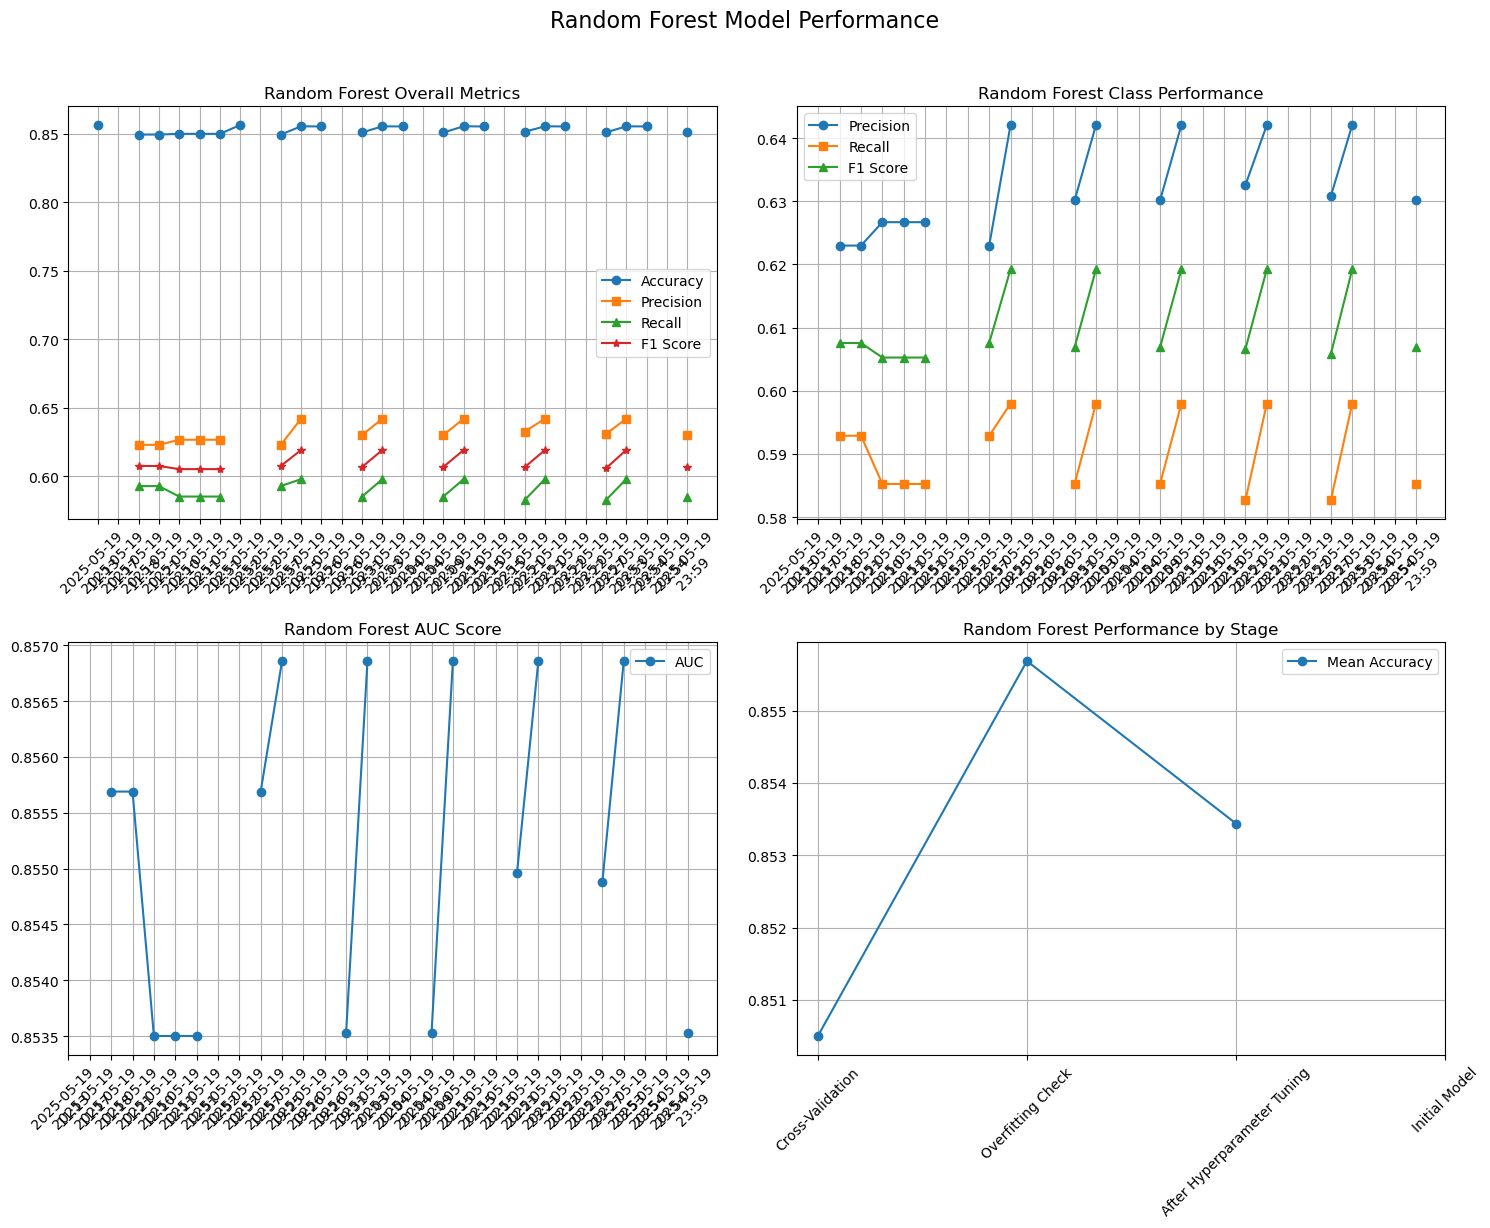

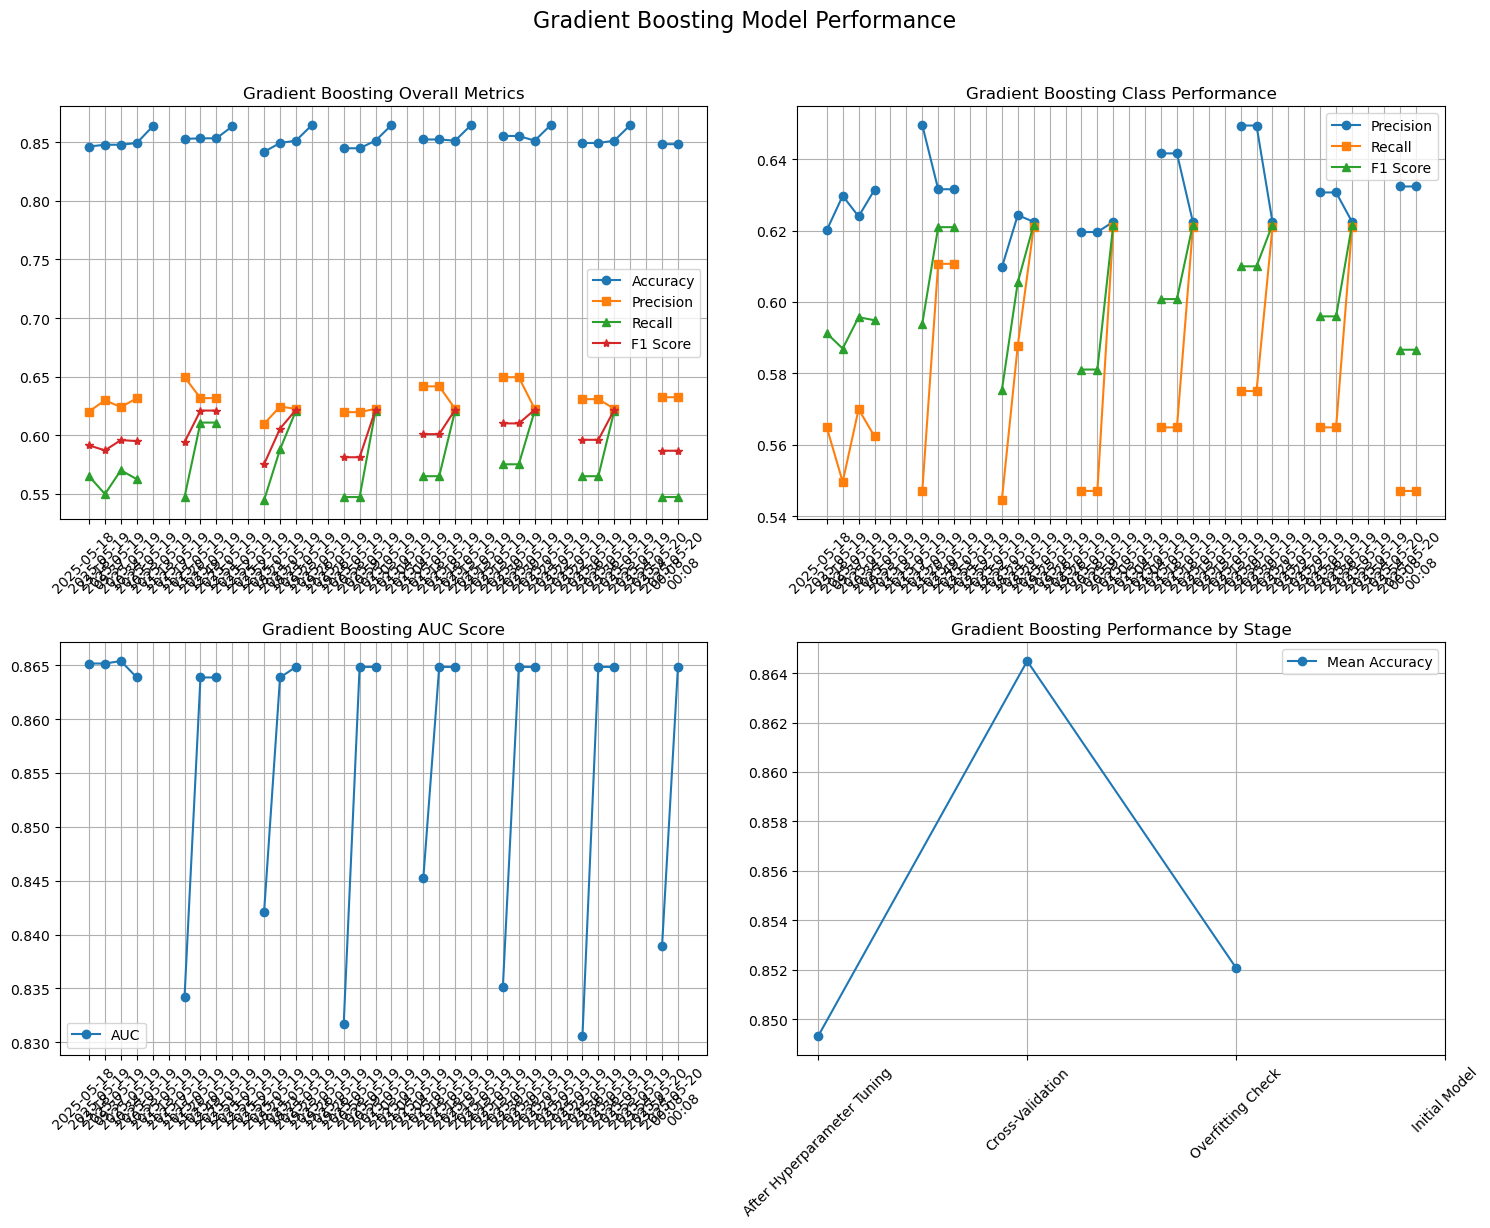


Random Forest Performance Summary:
        accuracy  precision     recall   f1_score        auc
count  23.000000  16.000000  16.000000  16.000000  16.000000
mean    0.853100   0.632084   0.590331   0.610480   0.855143
std     0.002738   0.007515   0.006233   0.006145   0.001453
min     0.849500   0.622995   0.582697   0.605263   0.853500
25%     0.850500   0.626703   0.585242   0.606422   0.853528
50%     0.855400   0.630137   0.589059   0.607211   0.855323
75%     0.855500   0.642077   0.597964   0.619236   0.856860
max     0.856400   0.642077   0.597964   0.619236   0.856860

Gradient Boosting Performance Summary:
        accuracy  precision     recall   f1_score        auc
count  31.000000  24.000000  24.000000  24.000000  24.000000
mean    0.853368   0.629648   0.577078   0.601777   0.856562
std     0.006774   0.010433   0.028963   0.015357   0.013225
min     0.842000   0.609687   0.544529   0.575269   0.830585
25%     0.849000   0.622449   0.548982   0.590148   0.844442
50%     0

In [41]:
# Read the CSV file and create plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
results_df = pd.read_csv('model_results_log.csv')
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])

# Debug: Print unique values in the model column
print("Unique model values:", results_df['model'].unique())

# Filter data for each model type
rf_data = results_df[results_df['model'].str.contains('RF', na=False)]
gbm_data = results_df[results_df['model'].str.contains('GBM', na=False)]

# Debug: Print data sizes
print(f"\nNumber of RF records: {len(rf_data)}")
print(f"Number of GBM records: {len(gbm_data)}")

# Modified plot_metrics function
def plot_metrics(data, ax1, ax2, ax3, ax4, model_name):
    if len(data) == 0:
        print(f"No data available for {model_name}")
        return
        
    # Format timestamps for x-axis
    timestamps = data['timestamp'].dt.strftime('%Y-%m-%d\n%H:%M')
    
    # Overall Metrics
    ax1.plot(range(len(data)), data['accuracy'], marker='o', label='Accuracy')
    ax1.plot(range(len(data)), data['precision'], marker='s', label='Precision')
    ax1.plot(range(len(data)), data['recall'], marker='^', label='Recall')
    ax1.plot(range(len(data)), data['f1_score'], marker='*', label='F1 Score')
    ax1.set_xticks(range(len(data)))
    ax1.set_xticklabels(timestamps, rotation=45)
    ax1.set_title(f'{model_name} Overall Metrics')
    ax1.legend()
    ax1.grid(True)

    # Class Performance
    ax2.plot(range(len(data)), data['precision'], marker='o', label='Precision')
    ax2.plot(range(len(data)), data['recall'], marker='s', label='Recall')
    ax2.plot(range(len(data)), data['f1_score'], marker='^', label='F1 Score')
    ax2.set_xticks(range(len(data)))
    ax2.set_xticklabels(timestamps, rotation=45)
    ax2.set_title(f'{model_name} Class Performance')
    ax2.legend()
    ax2.grid(True)

    # AUC Score
    if 'auc' in data.columns:
        ax3.plot(range(len(data)), data['auc'], marker='o', label='AUC')
        ax3.set_xticks(range(len(data)))
        ax3.set_xticklabels(timestamps, rotation=45)
        ax3.set_title(f'{model_name} AUC Score')
        ax3.legend()
        ax3.grid(True)

    # Stage Performance
    if 'stage' in data.columns:
        stages = data['stage'].unique()
        stage_means = data.groupby('stage')['accuracy'].mean()
        ax4.plot(range(len(stages)), stage_means.values, marker='o', label='Mean Accuracy')
        ax4.set_xticks(range(len(stages)))
        ax4.set_xticklabels(stages, rotation=45)
        ax4.set_title(f'{model_name} Performance by Stage')
        ax4.legend()
        ax4.grid(True)

# Create and plot figures
fig_rf, ((ax1_rf, ax2_rf), (ax3_rf, ax4_rf)) = plt.subplots(2, 2, figsize=(15, 12))
fig_rf.suptitle('Random Forest Model Performance', fontsize=16, y=1.02)
plot_metrics(rf_data, ax1_rf, ax2_rf, ax3_rf, ax4_rf, 'Random Forest')
plt.tight_layout()
plt.show()

fig_gbm, ((ax1_gbm, ax2_gbm), (ax3_gbm, ax4_gbm)) = plt.subplots(2, 2, figsize=(15, 12))
fig_gbm.suptitle('Gradient Boosting Model Performance', fontsize=16, y=1.02)
plot_metrics(gbm_data, ax1_gbm, ax2_gbm, ax3_gbm, ax4_gbm, 'Gradient Boosting')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nRandom Forest Performance Summary:")
if len(rf_data) > 0:
    print(rf_data[['accuracy', 'precision', 'recall', 'f1_score', 'auc']].describe())
else:
    print("No Random Forest data available")

print("\nGradient Boosting Performance Summary:")
if len(gbm_data) > 0:
    print(gbm_data[['accuracy', 'precision', 'recall', 'f1_score', 'auc']].describe())
else:
    print("No Gradient Boosting data available")

In [42]:
# Check the contents of your results log
print("\nFirst few rows of results log:")
print(results_df.head())
print("\nColumns in results log:")
print(results_df.columns.tolist())


First few rows of results log:
            timestamp          model                        stage  \
0 2025-05-18 23:18:27  Random Forest  After Hyperparameter Tuning   
1 2025-05-18 23:18:27            GBM  After Hyperparameter Tuning   
2 2025-05-19 09:37:57  Random Forest  After Hyperparameter Tuning   
3 2025-05-19 09:37:57            GBM  After Hyperparameter Tuning   
4 2025-05-19 10:34:01  Random Forest  After Hyperparameter Tuning   

   n_estimators  max_depth  min_samples_split  min_samples_leaf  accuracy  \
0         200.0        NaN                2.0               1.0    0.8465   
1         100.0        NaN                5.0               2.0    0.8465   
2          50.0        NaN                2.0               1.0    0.8480   
3         100.0        NaN                5.0               2.0    0.8480   
4         100.0        NaN                2.0               1.0    0.8480   

   precision    recall  ...  Balance  EstimatedSalary  Balance_Activity  \
0   0.620112  0

In [43]:
# Diagnostic checks
print("Number of total records:", len(results_df))
print("\nUnique model types:", results_df['model'].unique())
print("\nNumber of RF records:", len(rf_data))
print("Number of GBM records:", len(gbm_data))

# Check GBM data structure
if len(gbm_data) > 0:
    print("\nGBM data columns:", gbm_data.columns.tolist())
    print("\nGBM data sample:")
    # Use only the columns that exist in the DataFrame
    print(gbm_data[['timestamp', 'accuracy', 'precision', 'recall', 'f1_score']].head())
else:
    print("\nNo GBM data found. Check if:")
    print("1. GBM results were properly logged")
    print("2. The model field matches exactly 'GBM'")
    print("3. All required metrics were saved")

Number of total records: 79

Unique model types: ['Random Forest' 'GBM' 'RF' 'Drift Detection']

Number of RF records: 30
Number of GBM records: 38

GBM data columns: ['timestamp', 'model', 'stage', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'accuracy', 'precision', 'recall', 'f1_score', 'auc', 'learning_rate', 'random_state', 'cv_folds', 'std_accuracy', 'class0_precision', 'class0_recall', 'class0_f1', 'class1_precision', 'class1_recall', 'class1_f1', 'fit_status', 'train_score', 'test_score', 'cv_mean', 'cv_std', 'delta_train_test', 'delta_train_cv', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Balance_Activity', 'Age_Tenure', 'Balance_Per_Product', 'total_features_tested', 'features_with_drift', 'avg_p_value', 'max_mean_difference', 'severe_drift_features']

GBM data sample:
            timestamp  accuracy  precision    recall  f1_score
1 2025-05-18 23:18:27    0.8465   0.620112  0.564885  0.591212
3 2025-05-19 09:37:57    0.8480   0.629738  0.5496

## Part 2.2: Create New Features

Creating new features through feature engineering helps to improve performance of the machine learning models. Common feature engineering techniques include:

**Binning:** grouping continuous values into bins or categories. E.g. Age can be binned into ’0-29’, ’30-59’ and ’60+’.

**Aggregation:** combining multipledata points into one. E.g. Transaction data can be aggregated into an average transaction amount for a certain period, such as a week, month or quarter.

**One-hot encoding:** a process of converting categorical variables into binary vectors, helping machine learning algorithms to understand the individual labels better, thereby enhancing model performance.

**Feature scaling:** used to standardise the range of independent variables or features of data. E.g. 'Annual_Income' and 'Number_of_Dependents' have completely different ranges and if not scaled, the models that measure distances will bias towards the larger range feature; in this case 'Annual_Income'.

**Log and power transformations:** a logarithm is like a reverse multiplication, it tells you how many times you need to multiply a number by itself to get another number. A power calculation is when you take a number (x) and a power (p) to get a power transformation number. Common power transformations include square root (p=0.5), reciprocal (p=-1) and square (p=2), however any number can used as a power number.

(Topic 7.2 Feature Enhancements, Common feature engineering techniques)

### Part 2.2.1: Feature Engineering

**Feature Engineering and Tree-Based Models**
For Random Forest and Gradient Boosting Machine models, feature scaling is generally not required because:

1. **Tree-based models** like RF and GBM are invariant to monotonic transformations of individual features. They make decisions based on splitting points in the data rather than distances between points.

2. **Why scaling isn't needed:**

* Trees split data into groups using thresholds
* The absolute values don't matter, only the relative ordering
* Trees can handle different scales naturally

However, as the marking rubric for this assessment specifically requests Feature Engineering, we will carry out some techniques in an appropiate manner, outlined below.


**One-hot encoding**
For this assessment, the following data features have been feature engineered using the "one-hot encoding" technique and the Pandas "get_dummies" library function:
* Geography
* Gender
* Card Type

**Please note** that for one-hot encoding, the function has dropped the CardType value for "DIAMOND" customers, one might assume that the model will incorrectly identify that the missing data label will cause a large number of false positives for "DIAMOND" card types, but together with the "HasCrCard" column, the model can accurately determine the correct number of "DIAMOND" Card Type customers.

df = pd.get_dummies(df, columns=['Geography', 'Gender', 'Card Type'], drop_first=True) has been executed at the beginning of this python notebook, under the Part 1.0.3 of this workbook titled "Defining Features and Target Variable".

**Binning**
For this assessment, we will not use binning.

**Feature scaling**
For this assessment, we will use the Standard Scaling technique, except for the data features below:
* 

## Part 2.3: Consider data quality enhancements to improve the model

The synthetic minority oversampling technique (SMOTE) oversampling technique has been chosen as a data quality enhancement. The nearest neighbour parameter for SMOTE has been set to 5 to keep the computation manageable while capturing enough of the local structure of the data.

# Part 3: Maintaining Model Quality

## Part 3.1: Detecting Model Drift


Drift Detection Summary:
Feature: Balance_Activity
Drift Severity: High
P-value: 0.0000
Mean Difference: 35163.75
Std Difference: 8765.05
--------------------------------------------------------------------------------
Feature: Balance_Per_Product
Drift Severity: High
P-value: 0.0000
Mean Difference: 21752.84
Std Difference: 4907.55
--------------------------------------------------------------------------------
Feature: Product_Activity_Score
Drift Severity: High
P-value: 0.0000
Mean Difference: 0.43
Std Difference: 0.09
--------------------------------------------------------------------------------
Feature: Value_Activity_Score
Drift Severity: High
P-value: 0.0000
Mean Difference: 131010.85
Std Difference: 31200.70
--------------------------------------------------------------------------------
Feature: Balance_Credit_Ratio
Drift Severity: High
P-value: 0.0000
Mean Difference: 39.95
Std Difference: 5.90
-------------------------------------------------------------------------------

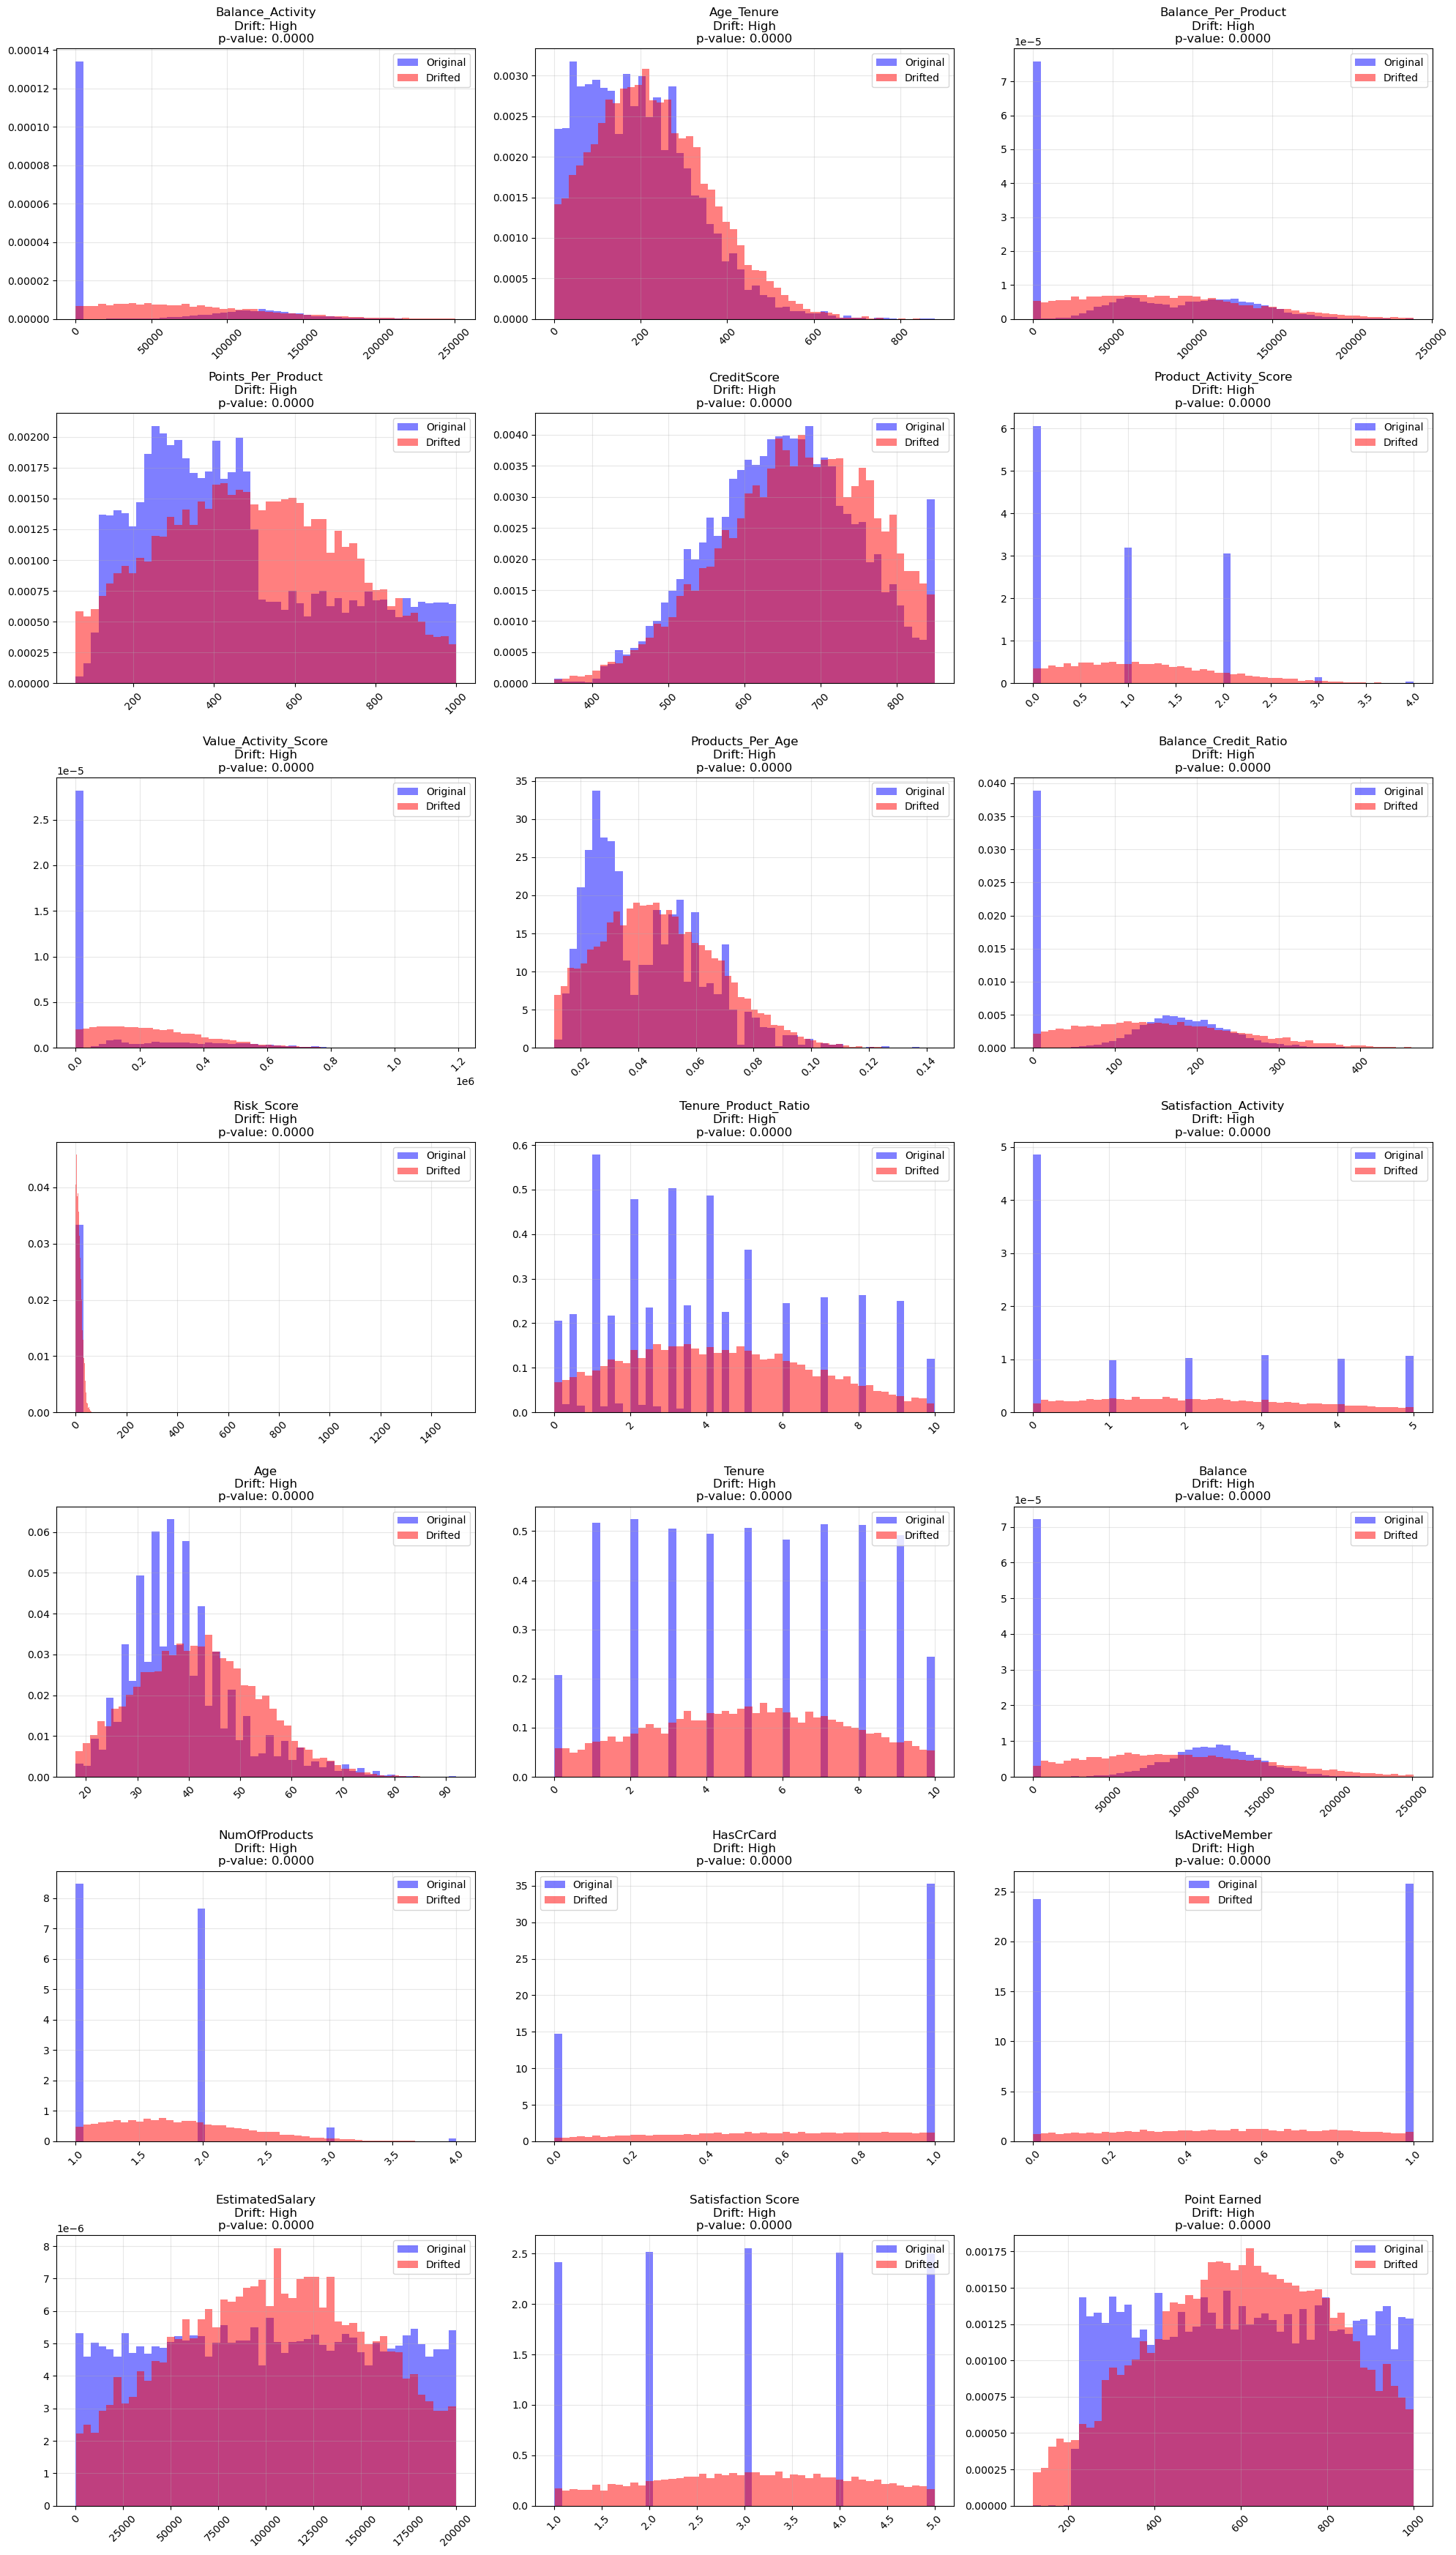

Results logged successfully to model_results_log.csv


In [44]:
# Function to detect and monitor model drift
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    """Generate truncated normal distribution"""
    return stats.truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def detect_drift(original_data, new_data, feature, threshold=0.05):
    """Detect drift between distributions using KS test"""
    try:
        orig_values = original_data[feature].dropna()
        new_values = new_data[feature].dropna()
        
        statistic, p_value = stats.ks_2samp(orig_values, new_values)
        mean_diff = abs(orig_values.mean() - new_values.mean())
        std_diff = abs(orig_values.std() - new_values.std())
        
        return {
            'feature': feature,
            'statistic': statistic,
            'p_value': p_value,
            'drift_detected': p_value < threshold,
            'mean_difference': mean_diff,
            'std_difference': std_diff,
            'drift_severity': 'High' if p_value < threshold/10 else 'Medium' if p_value < threshold else 'Low'
        }
    except Exception as e:
        print(f"Error detecting drift for feature {feature}: {str(e)}")
        return None

def generate_drift_data(original_data, drift_params):
    """Generate synthetic data with controlled drift"""
    drifted_data = original_data.copy()
    
    for feature, params in drift_params.items():
        if feature in original_data.columns:
            try:
                mean = original_data[feature].mean()
                std = original_data[feature].std()
                
                drifted_data[feature] = get_truncated_normal(
                    mean=mean + params['mean_shift'],
                    sd=std * params['std_multiplier'],
                    low=original_data[feature].min(),
                    upp=original_data[feature].max()
                ).rvs(len(original_data))
            except Exception as e:
                print(f"Error generating drift for {feature}: {str(e)}")
                continue
    
    return drifted_data

def visualize_drift(original_data, drifted_data, drift_params, drift_results, n_cols=3):
    """Create drift visualization plots"""
    n_features = len(drift_params)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 5*n_rows))
    
    for i, feature in enumerate(drift_params.keys(), 1):
        ax = plt.subplot(n_rows, n_cols, i)
        
        plt.hist(original_data[feature], bins=50, alpha=0.5, label='Original', 
                density=True, color='blue')
        plt.hist(drifted_data[feature], bins=50, alpha=0.5, label='Drifted',
                density=True, color='red')
        
        result = next((r for r in drift_results if r['feature'] == feature), None)
        if result:
            plt.title(f"{feature}\nDrift: {result['drift_severity']}\n" 
                     f"p-value: {result['p_value']:.4f}")
        
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    return fig

# Get all numeric features from the dataset
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Define drift parameters for all numeric features
drift_params = {}
for feature in numeric_features:
    # Set default drift parameters based on feature statistics
    mean = X[feature].mean()
    std = X[feature].std()
    
    # Use 5% of mean for mean_shift and 20% increase for std_multiplier
    drift_params[feature] = {
        'mean_shift': mean * 0.05,
        'std_multiplier': 1.2
    }

# Generate drifted data and detect drift
drifted_data = generate_drift_data(X, drift_params)
drift_results = []

for feature in drift_params.keys():
    result = detect_drift(X, drifted_data, feature)
    if result:
        drift_results.append(result)

# Sort results by drift severity
drift_results.sort(key=lambda x: x['p_value'] if x['p_value'] is not None else 1)

# Print drift detection summary
print("\nDrift Detection Summary:")
print("=" * 80)
for result in drift_results:
    print(f"Feature: {result['feature']}")
    print(f"Drift Severity: {result['drift_severity']}")
    print(f"P-value: {result['p_value']:.4f}")
    print(f"Mean Difference: {result['mean_difference']:.2f}")
    print(f"Std Difference: {result['std_difference']:.2f}")
    print("-" * 80)

# Visualize and log results
fig = visualize_drift(X, drifted_data, drift_params, drift_results)
plt.show()

# Log drift metrics
drift_metrics = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_features_tested': len(drift_results),
    'features_with_drift': sum(r['drift_detected'] for r in drift_results),
    'avg_p_value': np.mean([r['p_value'] for r in drift_results]),
    'max_mean_difference': max(r['mean_difference'] for r in drift_results),
    'severe_drift_features': sum(1 for r in drift_results if r['drift_severity'] == 'High')
}

log_model_results(
    model_name='Drift Detection',
    stage='Feature Drift Analysis',
    parameters=drift_params,
    metrics=drift_metrics
)

# Appendices

## Appendix 1: Results of "One-Hot Encoding"

In [45]:
# Display first 20 rows of the dataframe after one-hot encoding
print("\nShape of dataframe:", df.shape)
print("\nColumns after one-hot encoding:")
print(df.columns.tolist())
print("\nFirst 20 rows of encoded dataframe:")
print(df.head(20))


Shape of dataframe: (10000, 36)

Columns after one-hot encoding:
['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain', 'Satisfaction Score', 'Point Earned', 'Balance_Activity', 'Age_Tenure', 'Balance_Per_Product', 'Points_Per_Product', 'Product_Activity_Score', 'Value_Activity_Score', 'Age_Young', 'Age_Middle', 'Age_Senior', 'Age_Elderly', 'Products_Per_Age', 'Balance_Credit_Ratio', 'Risk_Score', 'Tenure_Product_Ratio', 'Satisfaction_Activity', 'Geography_QLD', 'Geography_VIC', 'Gender_Male', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER']

First 20 rows of encoded dataframe:
    RowNumber  CustomerId    Surname  CreditScore  Age  Tenure    Balance  \
0           1    15634602   Hargrave          619   42       2       0.00   
1           2    15647311       Hill          608   41       1   83807.86   
2           3    15619304       Onio          502   42  

## Appendix 2: Round 1 Model Performance Results (Including the "Complain" Data Feature)

### RF Classification Report Round 1 (Including "Complain" Data Feature)

Accuracy: 99.90%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


### RF AUC and Confusion Matrix Report Round 1 (Including "Complain" Data Feature)

AUC: 0.9982416305254841
Confusion Matrix:

[[1605    2]

 [   1  392]]

Precision: 0.9949238578680203, Recall: 0.9974554707379135, Accuracy: 0.9985



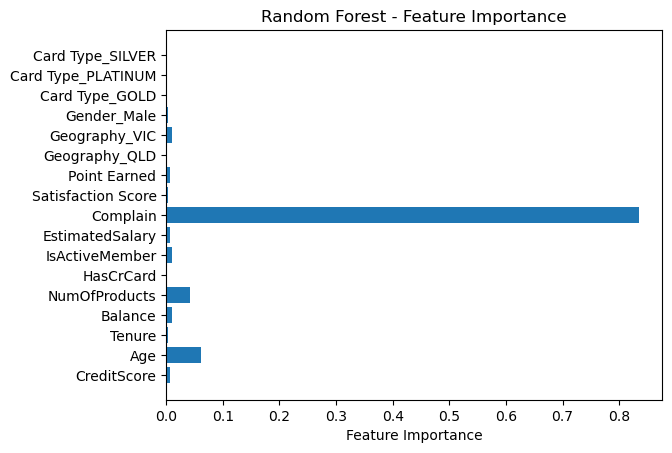

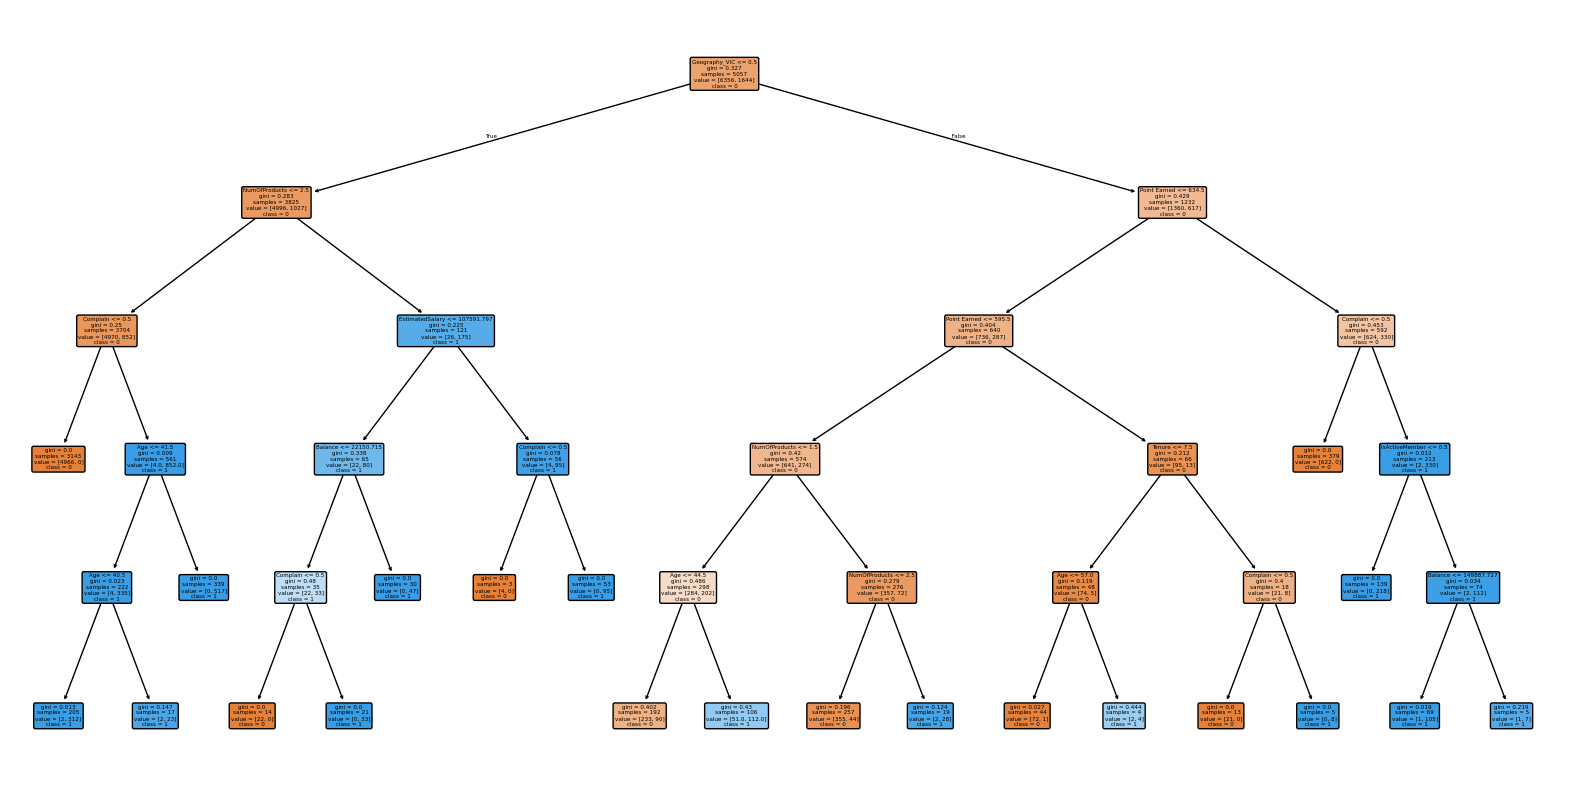

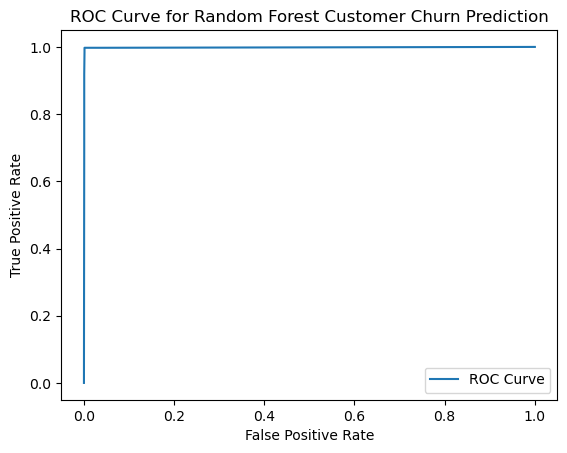

### GBM Performance Metrics Round 1 (Including "Complain" Data Feature)


AUC: 0.9982416305254841

Accuracy: 99.80%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       0.99      1.00      0.99       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:

[[1604    3]

 [   1  392]]


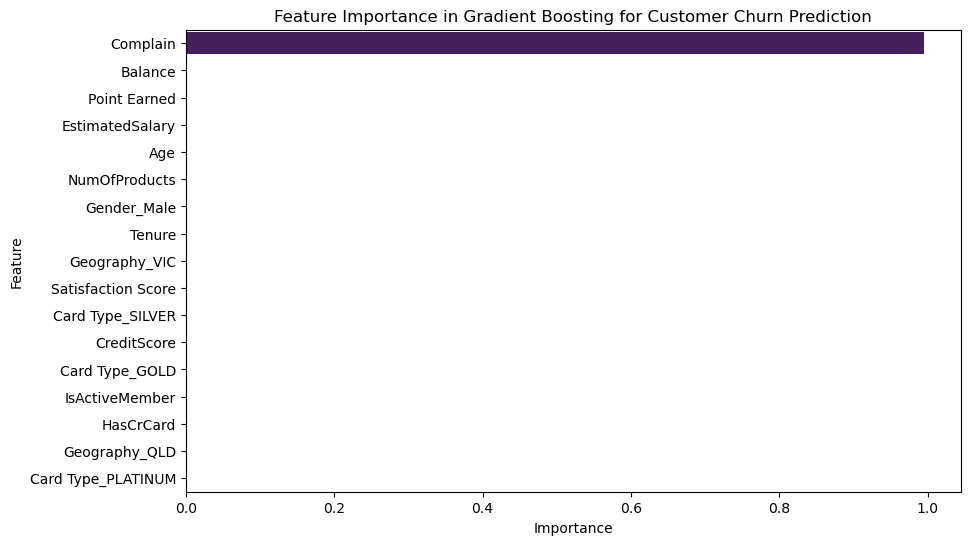

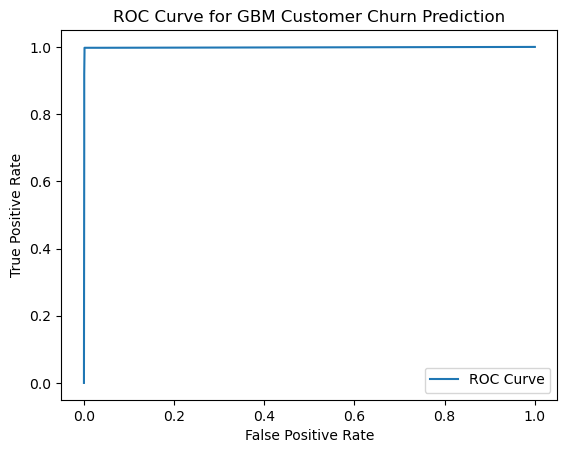

### Round 1 Cross-Validation Results (Including "Complain" Data feature)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7962
           1       1.00      1.00      1.00      2038

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


Gradient Boosting Cross-Validation Results:
CV Accuracy Scores: [0.9945 1.     0.9995 1.     0.998 ]
Mean CV Accuracy: 0.9984
Standard Deviation: 0.0021

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7962
           1       0.99      1.00      1.00      2038

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

### Round 1 RF Overfitting Check (Including "Complain" Data Feature)

Random Forest Overfitting Check:
Training Score: 1.0000
Test Score: 0.9990
CV Mean Score: 0.9986
CV Standard Deviation: 0.0020
Model appears to be well-fitted

## Appendix 3: Round 1 Hyperparameter Tuning Metrics (Including "Complain" Data Variable)



### RF Hyperparameter Tuning Results

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Accuracy: 0.999

Precision: 0.9974554707379135

Recall: 0.9974554707379135

F1 score: 0.9974554707379135

Hyperparameter tuning took: 82.93 seconds

### GBM Hyperparameter Tuning Results

Best parameters for GBM: {'learning_rate': 0.01, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Accuracy: 0.999

Precision: 0.9974554707379135

Recall: 0.9974554707379135

F1 score: 0.9974554707379135

Hyperparameter tuning took: 895.61 seconds

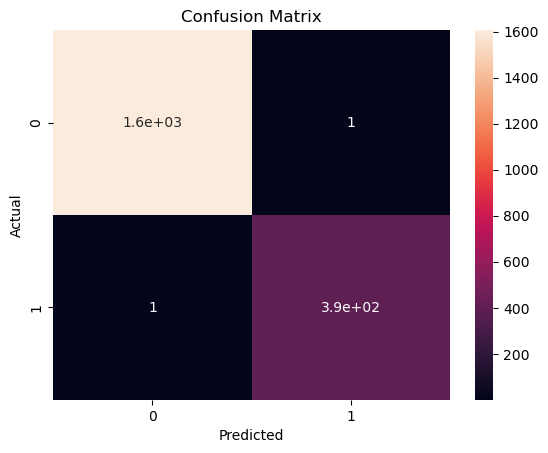